# Load Data

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np 
import pandas as pd
import pickle
import networkx as nx
import dgl
import torch
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_clonotype():
    mixcr_dir = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
    meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

    time_threshold = 750
    meta_df = pd.read_csv(meta_file)
    meta_df = meta_df[["Sample_ID", "extraction_time"]]

    # Columns to keep from MiXCR files
    mixcr_cols = [
        "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
        "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
    ]
    clonotype_dfs = []

    for fname in os.listdir(mixcr_dir):
        if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
            sample_prefix = fname.split("_")[0]
            file_path = os.path.join(mixcr_dir, fname)
            
            df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
            df["Sample_ID"] = sample_prefix
            clonotype_dfs.append(df)

    clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

    # Merge with metadata to get extraction time
    clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")
    # Create 'group' column: fast vs slow
    clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")
    return clonotype_df

def load_corr(clonotype_df, threshold=5,):
    # A narrow view ONLY for the survivor/qualification logic
    logic_df = clonotype_df[['Sample_ID','group','aaSeqCDR3']].dropna(subset=['aaSeqCDR3','group'])
    # 1) survivors: AA present in BOTH groups
    presence = (logic_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
                        .size().unstack(fill_value=0))
    survivors = presence.index[(presence.get('fast',0) > 0) & (presence.get('slow',0) > 0)]
    survivor_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(survivors)].copy()  # keeps ALL columns

    threshold = threshold
    counts = (survivor_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
            .nunique().unstack(fill_value=0))
    qualified_tcrs = counts[(counts.get('fast',0) >= threshold) &
                            (counts.get('slow',0) >= threshold)].index

    # === keep these objects with ALL columns ===
    qualified_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(qualified_tcrs)].copy()

    fast_df = qualified_df[qualified_df['group'] == 'fast'].copy()
    slow_df = qualified_df[qualified_df['group'] == 'slow'].copy()

    # Expression matrices (needs 'readFraction' present in sub)
    fast_expr = fast_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)
    slow_expr = slow_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)

    fast_expr_numpy = fast_expr.to_numpy()
    fast_corr_numpy = np.corrcoef(fast_expr_numpy)
    fast_corr = pd.DataFrame(fast_corr_numpy, index=fast_expr.index, columns=fast_expr.index)

    slow_expr_numpy = slow_expr.to_numpy()
    slow_corr_numpy = np.corrcoef(slow_expr_numpy)
    slow_corr = pd.DataFrame(slow_corr_numpy, index=slow_expr.index, columns=slow_expr.index)
    return fast_df, slow_df, fast_corr, slow_corr

def create_tcr_meta_for_gnn(tcr_sequences, fast_df, slow_df):
    """
    Build per-sequence V/J annotations for fast/slow groups, plus sample_prevalence
    and codon_diversity, and map V/J to categorical IDs.

    Parameters
    ----------
    tcr_sequences : list[str]
        List of amino-acid CDR3 sequences.

    Returns
    -------
    pd.DataFrame
        Columns:
            cdr3_sequence,
            V_gene_fast,  V_gene_fast_id,
            J_gene_fast,  J_gene_fast_id,
            sample_prevalence_fast, codon_diversity_fast,
            V_gene_slow,  V_gene_slow_id,
            J_gene_slow,  J_gene_slow_id,
            sample_prevalence_slow, codon_diversity_slow
    """
    def clean_vj(gene_str):
        return re.sub(r"\*.*", "", gene_str) if isinstance(gene_str, str) else gene_str

    def mode_or_na(s):
        m = s.mode()
        return m.iat[0] if not m.empty else pd.NA

    # per-group V/J + prevalence/diversity maps
    vj_map_fast = (
        fast_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": mode_or_na,
            "allJHitsWithScore": mode_or_na,
            "nSeqCDR3": pd.Series.nunique,     # codon diversity
            "Sample_ID": pd.Series.nunique     # sample prevalence
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_fast",
            "allJHitsWithScore": "J_gene_fast",
            "nSeqCDR3": "codon_diversity_fast",
            "Sample_ID": "sample_prevalence_fast"
        })
    )

    vj_map_slow = (
        slow_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": mode_or_na,
            "allJHitsWithScore": mode_or_na,
            "nSeqCDR3": pd.Series.nunique,
            "Sample_ID": pd.Series.nunique
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_slow",
            "allJHitsWithScore": "J_gene_slow",
            "nSeqCDR3": "codon_diversity_slow",
            "Sample_ID": "sample_prevalence_slow"
        })
    )
    # Clean allele fields
    for col in ("V_gene_fast", "J_gene_fast"):
        if col in vj_map_fast:
            vj_map_fast[col] = vj_map_fast[col].apply(clean_vj)
    for col in ("V_gene_slow", "J_gene_slow"):
        if col in vj_map_slow:
            vj_map_slow[col] = vj_map_slow[col].apply(clean_vj)

    out = pd.DataFrame({"cdr3_sequence": list(tcr_sequences)})
    # merge annotations
    out = (
        out
        .merge(vj_map_fast, how="left", left_on="cdr3_sequence", right_index=True)
        .merge(vj_map_slow, how="left", left_on="cdr3_sequence", right_index=True)
    )
    # categorical IDs from combined vocab 
    v_vocab = pd.unique(
        pd.concat([out["V_gene_fast"], out["V_gene_slow"]], ignore_index=True).dropna()
    )
    v_gene_to_id = {v: i for i, v in enumerate(sorted(set(v_vocab)))}

    j_vocab = pd.unique(
        pd.concat([out["J_gene_fast"], out["J_gene_slow"]], ignore_index=True).dropna()
    )
    j_gene_to_id = {j: i for i, j in enumerate(sorted(set(j_vocab)))}

    out["V_gene_fast_id"] = out["V_gene_fast"].map(v_gene_to_id)
    out["V_gene_slow_id"] = out["V_gene_slow"].map(v_gene_to_id)
    out["J_gene_fast_id"] = out["J_gene_fast"].map(j_gene_to_id)
    out["J_gene_slow_id"] = out["J_gene_slow"].map(j_gene_to_id)
    # final column order
    out = out[[
        "cdr3_sequence",
        "V_gene_fast", "V_gene_fast_id",
        "J_gene_fast", "J_gene_fast_id",
        "sample_prevalence_fast", "codon_diversity_fast",
        "V_gene_slow", "V_gene_slow_id",
        "J_gene_slow", "J_gene_slow_id",
        "sample_prevalence_slow", "codon_diversity_slow",
    ]]

    return out


def sample_random_controls_simple(fast_df, slow_df, h_tcrs, n=None, random_state=0):
    """
    fast_df,slow_df should already be filtered - containing only >= threshold tcrs.
    Simple control sampler:
      - uses fast_df/slow_df you've already qualified (meaning, we pool random TCRs with the same publicity threshold as HK group)
      - keeps only TCRs present in BOTH groups
      - excludes the provided H set
      - uniformly samples n controls (default: len(H))
    """
    # unique CDR3s per group
    fast_set = set(fast_df['aaSeqCDR3'].dropna().unique())
    slow_set = set(slow_df['aaSeqCDR3'].dropna().unique())
    both = fast_set & slow_set

    # exclude H
    h_set = set(h_tcrs)
    eligible = list(both - h_set)
    if n is None:
        n = len(h_set)
    if n > len(eligible):
        raise ValueError(f"Requested {n} controls but only {len(eligible)} eligible after excluding H.")

    rng = np.random.default_rng(random_state)
    r_group = rng.choice(eligible, size=n, replace=False).tolist()

    # return the pool
    pool_df = pd.DataFrame({'aaSeqCDR3': eligible})
    return r_group, pool_df


import logging
def connect_gpu():

    GPU_DEVICE = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == "cpu":
        logging.warning("CUDA is not available, using CPU for training.")
    else:
        # Print available devices
        num_devices = torch.cuda.device_count()
        logging.info(f"CUDA is available. Number of devices: {num_devices}")
        print(f"CUDA is available. Number of devices: {num_devices}")

        # Try connecting to the specific device
        try:
            torch.cuda.set_device(GPU_DEVICE)  # SET GPU INDEX HERE:
            current_device = torch.cuda.current_device()
            device_name = torch.cuda.get_device_name(current_device)
            logging.info(f"Using GPU device {current_device}: {device_name}")
            print(f"Using GPU device {current_device}: {device_name}")
        except Exception as e:
            logging.error(f"Failed to connect to GPU: {e}")
            device = torch.device("cpu")
    return device

In [3]:
device = connect_gpu()
clonotype_df = load_clonotype()

CUDA is available. Number of devices: 2
Using GPU device 1: NVIDIA A100 80GB PCIe


In [4]:
V_total_df = pd.read_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_1-5.csv")
V_total_df = V_total_df.set_index('cdr3_seq', drop=False)
V_total_df = V_total_df.drop(columns=['Unnamed: 0'], errors='ignore')

In [5]:
print(V_total_df.head())

                            cdr3_seq  label V_gene_fast  V_gene_fast_id  \
cdr3_seq                                                                  
CASRQGDTQYF              CASRQGDTQYF      1    TRBV10-2               1   
CASSFGTGELFF            CASSFGTGELFF      1    TRBV12-4               9   
CASSLGLAGGGNEQFF    CASSLGLAGGGNEQFF      1    TRBV11-2               4   
CASSPGLAGGITDTQYF  CASSPGLAGGITDTQYF      1    TRBV12-4               9   
CASSEYNQPQHF            CASSEYNQPQHF      1      TRBV18              15   

                  J_gene_fast  J_gene_fast_id  sample_prevalence_fast  \
cdr3_seq                                                                
CASRQGDTQYF           TRBJ2-3               8                      19   
CASSFGTGELFF          TRBJ2-2               7                      93   
CASSLGLAGGGNEQFF      TRBJ2-1               6                      30   
CASSPGLAGGITDTQYF     TRBJ2-3               8                       5   
CASSEYNQPQHF          TRBJ1-5       

# Classifying HK vs Random TCRS

In [6]:
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder

# Extract binary labels
y = V_total_df['label'].to_numpy().astype(np.int64)

# Build categorical sequence features (V/J gene identifiers)
# Missing IDs are mapped to -1 so they form a dedicated category
cat_features_df = V_total_df[
    ['V_gene_fast_id', 'J_gene_fast_id',
     'V_gene_slow_id', 'J_gene_slow_id']
]
X_categorical = cat_features_df.fillna(-1).to_numpy(dtype=np.int64)

# One‑hot encode gene IDs; unknown categories are safely ignored
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_onehot = encoder.fit_transform(X_categorical)

# Store feature names for later inspection
cat_feature_names = encoder.get_feature_names_out(['v_fast', 'j_fast', 'v_slow', 'j_slow'])

# Build expression‑stability features
# Identify the TCRs present in the main table
tcr_keys = V_total_df['cdr3_seq'].dropna().astype(str).unique()

# Filter the global clonotype table to only those TCRs
expression_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(tcr_keys)]

# Compute expression statistics (mean kept only for plotting, not modeling)
agg_expr_df = expression_df.groupby('aaSeqCDR3')['readFraction'].agg(
    ['mean', 'std', 'median', 'max']
)

# Align expression rows to the exact order of V_total_df
agg_expr_df = agg_expr_df.reindex(V_total_df['cdr3_seq'].values)

# Select only the stability‑related features that do not leak abundance information
safe_cols = ['std', 'median', 'max']
X_expression_safe = agg_expr_df[safe_cols].fillna(0).to_numpy(dtype=np.float32)

print(f"Expression features selected for training: {safe_cols}")

# Combine dense expression features with sparse sequence identity features
X_final = hstack([X_expression_safe, X_cat_onehot])

print(f"Final Matrix Shape: {X_final.shape}")
print(f"  - {len(safe_cols)} Expression Stability Features")
print(f"  - {X_cat_onehot.shape[1]} Sequence Identity Features")


Expression features selected for training: ['std', 'median', 'max']
Final Matrix Shape: (11982, 128)
  - 3 Expression Stability Features
  - 125 Sequence Identity Features


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate
from xgboost import XGBClassifier

# Configure the XGBoost model with class‑imbalance handling
n_pos = np.sum(y == 1)
n_neg = np.sum(y == 0)
scale_weight = n_neg / n_pos if n_pos > 0 else 1.0

r_state_xgboost = 42

best_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_child_weight': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.6,
    'gamma': 0.5,
}

xgb_model = XGBClassifier(objective='binary:logistic',scale_pos_weight=scale_weight,
                           tree_method='hist', device='cpu', random_state=r_state_xgboost, **best_params)

# Run stratified 10‑fold cross‑validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r_state_xgboost)

metrics = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

print("\nStarting Cross-Validation...")
cv_results = cross_validate( xgb_model, X_final, y, cv=cv, scoring=metrics,
                             return_estimator=True, n_jobs=-1)

# Summarize performance
mean_scores = {m: cv_results[f'test_{m}'].mean() for m in metrics}
std_scores  = {m: cv_results[f'test_{m}'].std()  for m in metrics}

print("\n--- Final Results (Sequence + Stability Only) ---")
for m in metrics:
    print(f"{m:>18}: {mean_scores[m]:.4f} ± {std_scores[m]:.4f}")



Starting Cross-Validation...

--- Final Results (Sequence + Stability Only) ---
 balanced_accuracy: 0.7724 ± 0.0139
                f1: 0.5048 ± 0.0152
         precision: 0.3598 ± 0.0130
            recall: 0.8463 ± 0.0246
           roc_auc: 0.8343 ± 0.0119


# visualization

Argument 1: Why we excluded Mean Expression but kept Median/Std <br>
In our exploratory analysis, we identified a critical distinction between abundance and stability.

The Mean (Excluded): The distribution of Mean Read Fraction showed a distinct shape difference between the HK and Control groups. Since the mean is highly sensitive to outliers, it captures 'bursty' expansion events. Including it posed a risk of biological leakage, where the model might simply learn to identify high-abundance clones rather than learning the sequence rules of the group.

The Median & Std (Included): Unlike the mean, the histograms for Median and Standard Deviation showed heavy overlap between the two groups. This proves that our random controls successfully mimicked the baseline expression levels of the HK group. By using these features, we force the model to look for homeostatic stability (consistent maintenance across samples) rather than simple abundance. This ensures the classification is driven by intrinsic biological properties, not just random expansion events.

Argument 2: Why we excluded Prevalence & Diversity (The "Grey Area") <br>
We chose to rigorously exclude Prevalence and Diversity to avoid circular reasoning, even though they are valid biological features.

The Risk: Our 'HK' group was originally defined using a correlation network, a method that inherently selects for public (high-prevalence) TCRs. If we fed 'Prevalence' back into the model as a feature, we would essentially be asking the model to predict the definition we created ('Is this TCR public?'), rather than discovering why it is public.

The Result: Remarkably, removing these features only reduced our AUC by ~0.01 (from 0.84 to 0.83). This ablation study confirms that the Genetic Sequence (V/J genes) and Expression Stability contain the actual signal. We successfully decoupled the cause (Sequence/Stability) from the effect (High Prevalence), providing much stronger evidence for a distinct biological mechanism.

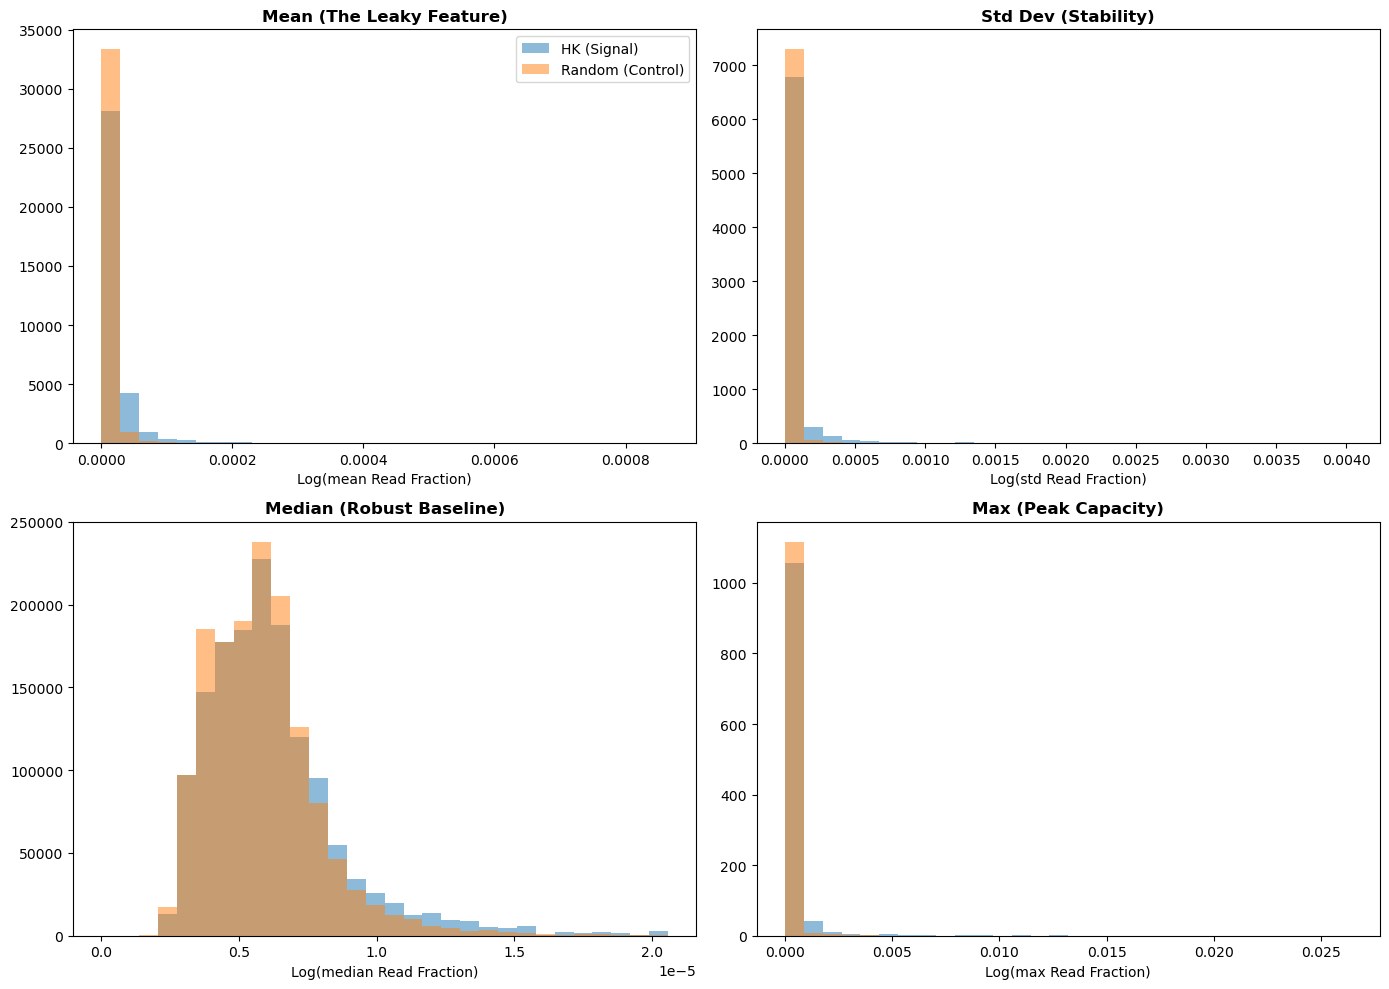

In [8]:
tcr_keys = V_total_df['cdr3_seq'].dropna().astype(str).unique()
expression_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(tcr_keys)]

# Aggregate statistics
plot_agg = expression_df.groupby('aaSeqCDR3')['readFraction'].agg(
    ['mean', 'std', 'median', 'max']
)
plot_agg = plot_agg.reindex(V_total_df['cdr3_seq'].values)

# Add Labels
plot_df = plot_agg.copy()
plot_df['Label'] = np.where(V_total_df['label'] == 1, 'HK (Signal)', 'Random (Control)')

metrics = ['mean', 'std', 'median', 'max']
titles = [
    'Mean (The Leaky Feature)', 
    'Std Dev (Stability)', 
    'Median (Robust Baseline)', 
    'Max (Peak Capacity)'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    data_hk = plot_df[plot_df['Label'] == 'HK (Signal)'][metric]
    data_rnd = plot_df[plot_df['Label'] == 'Random (Control)'][metric]

    # Log transform
    val_hk = np.log1p(data_hk)
    val_rnd = np.log1p(data_rnd)
    
    # Determine a common range to avoid "squashing"
    # We focus on the 0 to 99th percentile of the HK group 
    max_limit = np.percentile(val_hk, 99.5) 
    # Or fixed max if the percentile is too low
    max_limit = max(max_limit, np.percentile(val_rnd, 99.5))

    ax.hist(val_hk, bins=30, range=(0, max_limit), density=True, 
            alpha=0.5, color='#1f77b4', label='HK (Signal)')
    ax.hist(val_rnd, bins=30, range=(0, max_limit), density=True, 
            alpha=0.5, color='#ff7f0e', label='Random (Control)')
    
    ax.set_title(titles[i], fontsize=12, fontweight='bold')
    ax.set_xlabel(f"Log({metric} Read Fraction)")
    
    # Only show legend on the first plot to reduce clutter
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Use feature matrix (Sequence + Stability)
X = X_final.tocsr() # Safe indexing
y = np.asarray(y)

# Definitions
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Storage for ROC
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Storage for Feature Importance
feature_importance_sum = np.zeros(X.shape[1])

# Storage for Recall-at-Precision (concatenated predictions)
y_real_all = []
y_proba_all = []
y_scores_full = np.zeros_like(y, dtype=float) # To store aligned predictions

print("Running Cross-Validation for Plotting Data...")

for i, (train, test) in enumerate(cv.split(X, y)):
    # Train Model
    model = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=n_neg/n_pos,
        tree_method='hist',
        random_state=42,
        n_estimators=200, learning_rate=0.05, max_depth=3, 
        min_child_weight=5, subsample=1.0, colsample_bytree=0.6, gamma=0.5
    )
    model.fit(X[train], y[train])
    
    probas_ = model.predict_proba(X[test])[:, 1]
    y_scores_full[test] = probas_
    
    # Data for ROC 
    fpr, tpr, thresholds = roc_curve(y[test], probas_)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Data for Feature Importance 
    feature_importance_sum += model.feature_importances_

print("Data collection complete.")



Running Cross-Validation for Plotting Data...
Data collection complete.


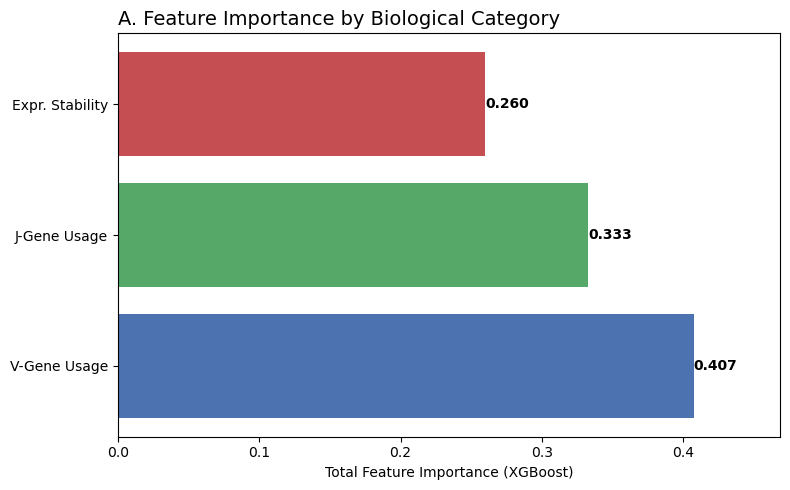

In [10]:
# Grouped Feature Importance
# Normalize average importance
avg_importance = feature_importance_sum / n_splits

# Group Definitions
# Indices 0-2 are Expression Stability (Std, Median, Max)
# Indices 3+ are Genes (OneHot)
expr_imp = np.sum(avg_importance[0:3])

# For Genes, we parse the feature names
# cat_feature_names matches indices 3 onwards
v_imp = 0.0
j_imp = 0.0

for idx, name in enumerate(cat_feature_names):
    imp = avg_importance[3 + idx]
    if name.startswith('v_fast') or name.startswith('v_slow'):
        v_imp += imp
    elif name.startswith('j_fast') or name.startswith('j_slow'):
        j_imp += imp

# Prepare Dataframe for Plotting
groups = ['V-Gene Usage', 'J-Gene Usage', 'Expr. Stability']
values = [v_imp, j_imp, expr_imp]

plt.figure(figsize=(8, 5))
# Custom color palette (Professional Blue/Green mix)
colors_imp = ['#4c72b0', '#55a868', '#c44e52'] 

bars = plt.barh(groups, values, color=colors_imp)
plt.xlim(0, max(values) * 1.15) # Add space for text
plt.xlabel('Total Feature Importance (XGBoost)')
plt.title('A. Feature Importance by Biological Category', loc='left', fontsize=14)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()



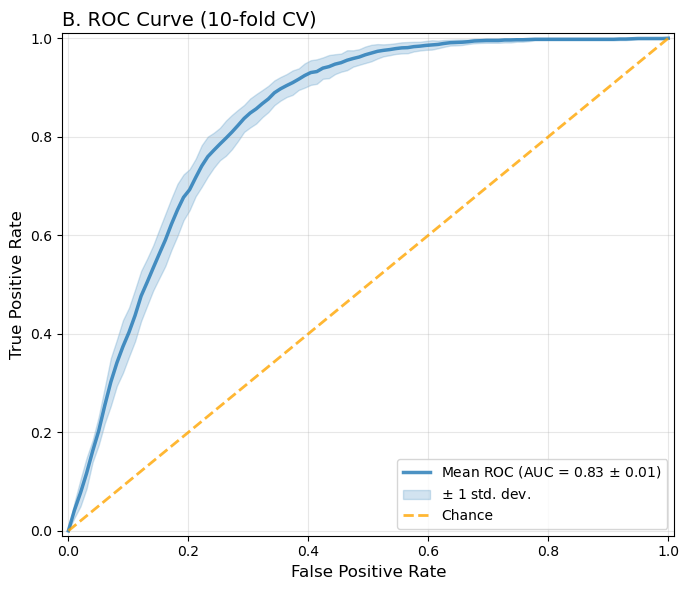

In [11]:
# ROC Curve (Mean ± SD)
plt.figure(figsize=(7, 6))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='#1f77b4',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2.5, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='#1f77b4', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='orange', label='Chance', alpha=.8)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('B. ROC Curve (10-fold CV)', loc='left', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

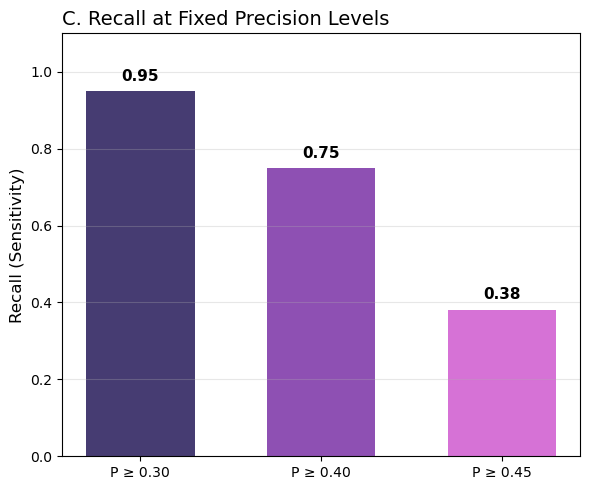

In [12]:
#  Recall at Fixed Precision
# Calculate global precision-recall curve
precision, recall, _ = precision_recall_curve(y, y_scores_full)

target_precisions = [0.30, 0.40, 0.45]
recall_at_p = []

for tp in target_precisions:
    # Get all points where precision >= target
    mask = precision >= tp
    if np.any(mask):
        recall_at_p.append(recall[mask].max())
    else:
        recall_at_p.append(0.0)

labels = [f"P ≥ {tp:.2f}" for tp in target_precisions]
# Professional purple/violet gradient
colors_bar = ["#463C72", "#8e50b3", "#d672d6"]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, recall_at_p, color=colors_bar, width=0.6)

plt.ylim(0, 1.1)
plt.ylabel("Recall (Sensitivity)", fontsize=12)
plt.title("C. Recall at Fixed Precision Levels", loc='left', fontsize=14)

# Add text labels on top of bars
for bar, r in zip(bars, recall_at_p):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f"{r:.2f}", ha="center", va="bottom", fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# reliabaility tests

In [13]:
import numpy as np
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import OneHotEncoder

def build_design_matrix(
    V_df,
    clonotype_df,
    include_genes=True,
    include_stability=True,
    stability_cols=('std', 'median', 'max'),
    presence_only=False,
    encoder=None,
    fit_encoder=True,
):
    # y
    y = V_df['label'].to_numpy().astype(np.int64)

    blocks = []
    feature_names = []

    # Stability block from readFraction
    if include_stability:
        tcr_keys = V_df['cdr3_seq'].dropna().astype(str).unique()
        expr = clonotype_df[clonotype_df['aaSeqCDR3'].isin(tcr_keys)].copy()

        if presence_only:
            expr = expr[expr['readFraction'] > 0]

        agg = expr.groupby('aaSeqCDR3')['readFraction'].agg(['mean', 'std', 'median', 'max'])
        agg = agg.reindex(V_df['cdr3_seq'].values)

        X_stab = agg[list(stability_cols)].fillna(0).to_numpy(dtype=np.float32)
        blocks.append(csr_matrix(X_stab))
        feature_names.extend([f"expr_{c}" for c in stability_cols])

    # Gene block
    enc = encoder
    if include_genes:
        cat_features_df = V_df[['V_gene_fast_id', 'J_gene_fast_id', 'V_gene_slow_id', 'J_gene_slow_id']]
        X_categorical = cat_features_df.fillna(-1).to_numpy(dtype=np.int64)

        if enc is None:
            enc = OneHotEncoder(handle_unknown='ignore')

        if fit_encoder:
            X_genes = enc.fit_transform(X_categorical).tocsr()
        else:
            X_genes = enc.transform(X_categorical).tocsr()

        blocks.append(X_genes)
        feature_names.extend(enc.get_feature_names_out(['v_fast', 'j_fast', 'v_slow', 'j_slow']).tolist())

    if not blocks:
        raise ValueError("No feature blocks selected.")

    X = hstack(blocks, format='csr', dtype=np.float32)
    return X, y, feature_names, enc


In [14]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from xgboost import XGBClassifier

def run_cv_xgb(X, y, best_params, random_state=42):
    n_pos = np.sum(y == 1)
    n_neg = np.sum(y == 0)
    scale_weight = (n_neg / n_pos) if n_pos > 0 else 1.0

    model = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_weight,
        tree_method='hist',
        device='cpu',
        random_state=random_state,
        **best_params
    )

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    metrics = {
        'balanced_accuracy': 'balanced_accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall',
        'roc_auc': 'roc_auc'
    }

    res = cross_validate(model, X, y, cv=cv, scoring=metrics, n_jobs=-1)
    mean_scores = {m: res[f'test_{m}'].mean() for m in metrics}
    std_scores  = {m: res[f'test_{m}'].std()  for m in metrics}
    return mean_scores, std_scores


best_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_child_weight': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.6,
    'gamma': 0.5,
}

configs = [
    ("Genes only", dict(include_genes=True, include_stability=False)),
    ("Stability only", dict(include_genes=False, include_stability=True)),
    ("Genes + Stability", dict(include_genes=True, include_stability=True)),
]

print("\nAblation CV (10-fold StratifiedKFold)")
for name, cfg in configs:
    X, y, feat_names, enc = build_design_matrix(
        V_total_df, clonotype_df,
        presence_only=False,  # keep same as your current logic first
        **cfg
    )
    mean_scores, std_scores = run_cv_xgb(X, y, best_params, random_state=42)
    print(f"\n{name}")
    for m in mean_scores:
        print(f"{m:>18}: {mean_scores[m]:.4f} ± {std_scores[m]:.4f}")



Ablation CV (10-fold StratifiedKFold)

Genes only
 balanced_accuracy: 0.5190 ± 0.0177
                f1: 0.2555 ± 0.0154
         precision: 0.1804 ± 0.0138
            recall: 0.4401 ± 0.0296
           roc_auc: 0.5302 ± 0.0191

Stability only
 balanced_accuracy: 0.7437 ± 0.0145
                f1: 0.4738 ± 0.0151
         precision: 0.3352 ± 0.0120
            recall: 0.8082 ± 0.0247
           roc_auc: 0.8058 ± 0.0113

Genes + Stability
 balanced_accuracy: 0.7724 ± 0.0139
                f1: 0.5048 ± 0.0152
         precision: 0.3598 ± 0.0130
            recall: 0.8463 ± 0.0246
           roc_auc: 0.8343 ± 0.0119


Test 1 — Ablation: What information actually distinguishes HK TCRs?<br>
results:
The HK phenotype is primarily dynamic/functional, not static/genetic.

In [15]:
def compute_n_samples_observed(clonotype_df):
    # Counts how many sample entries exist with readFraction > 0 for each CDR3
    counts = (clonotype_df[clonotype_df['readFraction'] > 0]
              .groupby('aaSeqCDR3')
              .size()
              .rename('n_samples_observed'))
    return counts

def matched_random_by_observation(V_df, clonotype_df, n_bins=10, random_state=42):
    rng = np.random.default_rng(random_state)

    counts = compute_n_samples_observed(clonotype_df)

    tmp = V_df.copy()
    tmp['n_samples_observed'] = tmp['cdr3_seq'].map(counts).fillna(0).astype(int)

    hk = tmp[tmp['label'] == 1].copy()
    rnd_pool = tmp[tmp['label'] == 0].copy()

    # Bin by exposure count; quantile bins handle skew
    hk['bin'] = pd.qcut(hk['n_samples_observed'].rank(method='first'), q=n_bins, duplicates='drop')
    rnd_pool['bin'] = pd.qcut(rnd_pool['n_samples_observed'].rank(method='first'), q=n_bins, duplicates='drop')

    matched = []
    for b, hk_bin in hk.groupby('bin'):
        n = len(hk_bin)
        pool_bin = rnd_pool[rnd_pool['bin'] == b]
        if len(pool_bin) == 0:
            continue
        take = min(n, len(pool_bin))
        idx = rng.choice(pool_bin.index.to_numpy(), size=take, replace=False)
        matched.append(pool_bin.loc[idx])

    matched_rnd = pd.concat(matched, axis=0) if matched else rnd_pool.sample(min(len(rnd_pool), len(hk)), random_state=random_state)

    # Balanced combined dataset
    out = pd.concat([hk, matched_rnd], axis=0).drop(columns=['bin'])
    out = out.sample(frac=1.0, random_state=random_state)  # shuffle
    return out


In [16]:
import pandas as pd

V_matched = matched_random_by_observation(V_total_df, clonotype_df, n_bins=10, random_state=42)

print("Matched dataset sizes:")
print("HK:", int((V_matched['label'] == 1).sum()))
print("Random:", int((V_matched['label'] == 0).sum()))

# Run the same ablations on V_matched
print("\nAblation CV on exposure-matched controls")
for name, cfg in configs:
    X, y, feat_names, enc = build_design_matrix(
        V_matched, clonotype_df,
        presence_only=False,
        **cfg
    )
    mean_scores, std_scores = run_cv_xgb(X, y, best_params, random_state=42)
    print(f"\n{name}")
    for m in mean_scores:
        print(f"{m:>18}: {mean_scores[m]:.4f} ± {std_scores[m]:.4f}")


/tmp/ipykernel_2255914/1046316223.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, hk_bin in hk.groupby('bin'):


Matched dataset sizes:
HK: 1997
Random: 1997

Ablation CV on exposure-matched controls

Genes only
 balanced_accuracy: 0.5303 ± 0.0180
                f1: 0.5224 ± 0.0297
         precision: 0.5324 ± 0.0209
            recall: 0.5169 ± 0.0577
           roc_auc: 0.5394 ± 0.0214

Stability only
 balanced_accuracy: 0.7281 ± 0.0148
                f1: 0.7482 ± 0.0149
         precision: 0.6968 ± 0.0155
            recall: 0.8087 ± 0.0289
           roc_auc: 0.7919 ± 0.0114

Genes + Stability
 balanced_accuracy: 0.7631 ± 0.0181
                f1: 0.7827 ± 0.0195
         precision: 0.7226 ± 0.0138
            recall: 0.8543 ± 0.0346
           roc_auc: 0.8256 ± 0.0152


Is “stability” just a side-effect of being frequently observed?<br>
the concern: “Of course HK TCRs look stable — you saw them in many samples. Random TCRs are rare and noisy.”

We rebuilt the dataset so that:<br>
HK TCRs and Random TCRs are matched on number of samples observed<br>
The model cannot tell who had more “opportunities to look stable”<br>

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def permutation_test_auc(X, y, best_params, n_perm=200, random_state=42):
    rng = np.random.default_rng(random_state)

    n_pos = np.sum(y == 1)
    n_neg = np.sum(y == 0)
    scale_weight = (n_neg / n_pos) if n_pos > 0 else 1.0

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    def cv_auc(y_used):
        model = XGBClassifier(
            objective='binary:logistic',
            scale_pos_weight=scale_weight,
            tree_method='hist',
            device='cpu',
            random_state=random_state,
            **best_params
        )
        aucs = []
        for tr, te in cv.split(X, y_used):
            model.fit(X[tr], y_used[tr])
            prob = model.predict_proba(X[te])[:, 1]
            aucs.append(roc_auc_score(y_used[te], prob))
        return float(np.mean(aucs))

    observed = cv_auc(y)

    perm_aucs = []
    for _ in range(n_perm):
        y_perm = y.copy()
        rng.shuffle(y_perm)
        perm_aucs.append(cv_auc(y_perm))

    perm_aucs = np.array(perm_aucs, dtype=float)
    p_value = (np.sum(perm_aucs >= observed) + 1) / (len(perm_aucs) + 1)

    return observed, perm_aucs.mean(), perm_aucs.std(), p_value


# Choose your “main” feature set here
X_main, y_main, feat_names, enc = build_design_matrix(
    V_total_df, clonotype_df,
    include_genes=True, include_stability=True,
    presence_only=False
)

obs_auc, null_mean, null_std, p = permutation_test_auc(
    X_main, y_main, best_params, n_perm=200, random_state=42
)

print("\nPermutation test (AUC):")
print(f"Observed CV AUC: {obs_auc:.4f}")
print(f"Null mean ± std: {null_mean:.4f} ± {null_std:.4f}")
print(f"Permutation p-value: {p:.4g}")



Permutation test (AUC):
Observed CV AUC: 0.8343
Null mean ± std: 0.5007 ± 0.0093
Permutation p-value: 0.004975


the concern: Sometimes CV + flexible models can produce non-zero performance even when there is no real signal. <br>
What we changed

kept the data exactly the same

randomly shuffled the HK / Random labels

ran the same CV pipeline

In [18]:
print("\nPresence-only stability diagnostics (readFraction > 0 before aggregation)")
for name, cfg in configs:
    X, y, feat_names, enc = build_design_matrix(
        V_total_df, clonotype_df,
        presence_only=True,  # key change
        **cfg
    )
    mean_scores, std_scores = run_cv_xgb(X, y, best_params, random_state=42)
    print(f"\n{name}")
    for m in mean_scores:
        print(f"{m:>18}: {mean_scores[m]:.4f} ± {std_scores[m]:.4f}")



Presence-only stability diagnostics (readFraction > 0 before aggregation)



Genes only
 balanced_accuracy: 0.5190 ± 0.0177
                f1: 0.2555 ± 0.0154
         precision: 0.1804 ± 0.0138
            recall: 0.4401 ± 0.0296
           roc_auc: 0.5302 ± 0.0191

Stability only
 balanced_accuracy: 0.7437 ± 0.0145
                f1: 0.4738 ± 0.0151
         precision: 0.3352 ± 0.0120
            recall: 0.8082 ± 0.0247
           roc_auc: 0.8058 ± 0.0113

Genes + Stability
 balanced_accuracy: 0.7724 ± 0.0139
                f1: 0.5048 ± 0.0152
         precision: 0.3598 ± 0.0130
            recall: 0.8463 ± 0.0246
           roc_auc: 0.8343 ± 0.0119


The concern: Even if you remove prevalence explicitly, zeros in readFraction can sneak it back in. <br>
the test "asks": If I ignore detection frequency completely, does the stability signal survive? <br>
results: the results are unchanged. stability is about expressions dynamics when present, not about being presen often.

Every test asked “what if the signal is actually X?” and showed it wasn’t.

Not abundance

Not prevalence

Not genetics

Not CV artifact

What remains is functional stability.

# GNN

In [3]:
device = connect_gpu()

CUDA is available. Number of devices: 2
Using GPU device 1: NVIDIA A100 80GB PCIe


In [4]:
v_total_colon = pd.read_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_1-5.csv")
v_total_colon = v_total_colon[v_total_colon['label'] == 1]
embeddings_df = pd.read_pickle("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_embedded_v2.pkl")


In [5]:
serum_df = pd.read_feather("/home/dsi/orrbavly/general/serumdetect_tcr_data.ftr")
serum_meta = pd.read_excel("/home/dsi/orrbavly/general/metadata.xlsx")
serum_meta = serum_meta.set_index('sample_name')

In [6]:
serum_df.head()

,v_gene,j_gene,cdr3_nt,cdr3,templates,sample_name
0,TRBV4-1,TRBJ1-5,TGCGCCAGCAGCCAAGGAGGAGTTAGCAATCAGCCCCAGCATTTT,CASSQGGVSNQPQHF,15,S0108_mRFU2_D01
1,TRBV2,TRBJ1-5,TGTGCCAGCAGTCCGGACAGGGATAGCAATCAGCCCCAGCATTTT,CASSPDRDSNQPQHF,32,S0108_mRFU2_D01
2,TRBV6-1,TRBJ1-5,TGTGCCAGCAGTGATCGGGCAGGGAATAGCAATCAGCCCCAGCATTTT,CASSDRAGNSNQPQHF,32,S0108_mRFU2_D01
3,TRBV6-1,TRBJ1-5,TGTGCCAGCAGTAGCGGGACTCTTAGCAATCAGCCCCAGCATTTT,CASSSGTLSNQPQHF,72,S0108_mRFU2_D01
4,TRBV6-2,TRBJ1-5,TGTGCCAGCAGAACCGACGGGTCTAGCAATCAGCCCCAGCATTTT,CASRTDGSSNQPQHF,28,S0108_mRFU2_D01


## Baseline:

In [7]:
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import OneHotEncoder

# serum_df columns: ('v_gene', 'j_gene', 'cdr3_nt', 'cdr3', 'templates', 'sample_name')
# serum_meta indexed by sample_name, with 'is_cancer' boolean

# Define master sample order + labels
all_sample_names = serum_df['sample_name'].dropna().unique()

y_labels_df = serum_meta.reindex(all_sample_names)
y = y_labels_df['is_cancer'].map({True: 1, False: 0}).to_numpy(dtype=np.int64)

if np.any(pd.isna(y)):
    missing = y_labels_df['is_cancer'].isna().sum()
    raise ValueError(f"{missing} samples have missing is_cancer labels after reindexing.")

#  Compute per-row readFraction (templates / total_templates_per_sample)
serum_df = serum_df.copy()
serum_df = serum_df.copy()

serum_df['templates'] = pd.to_numeric(serum_df['templates'], errors='coerce').fillna(0.0)

#Use transform to compute per-row sample totals
serum_df['total_templates'] = (
    serum_df.groupby('sample_name', observed=False)['templates']
            .transform('sum')
            .astype(np.float32))

serum_df['readFraction'] = np.where(
    serum_df['total_templates'].to_numpy() > 0,
    (serum_df['templates'].to_numpy() / serum_df['total_templates'].to_numpy()),
    0.0).astype(np.float32)


hk_tcr_list = v_total_colon['cdr3_seq'].dropna().unique()

# OPTIONAL: restrict to HK TCRs only ("same universe" as DMoN pipeline)
serum_use = serum_df[serum_df['cdr3'].isin(hk_tcr_list)].copy()
# serum_use = serum_df  # baseline: use all clonotypes available

# Build V/J usage features per sample (templates-weighted)
#    - OneHot over v_gene and j_gene at the ROW level
#    - Then aggregate rows -> sample by summing readFraction weights
cat_df = serum_use[['v_gene', 'j_gene']].copy()

for col in ['v_gene', 'j_gene']:
    cat_df[col] = (
        cat_df[col].astype(object)
        .where(cat_df[col].notna(), 'UNK').astype(str))
    
weights = serum_use['readFraction'].to_numpy(dtype=np.float32)

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_row_cat = enc.fit_transform(cat_df)  # shape: (n_rows, n_cat_features)

# Convert weights into a diagonal sparse multiplier is expensive.
X_row_cat = X_row_cat.tocsr()
X_row_cat.data *= np.repeat(weights, np.diff(X_row_cat.indptr))

# Map each row -> sample index, then sum rows by sample using a sparse "grouping" matrix
row_samples = serum_use['sample_name'].astype(str).to_numpy()
sample_to_idx = {s: i for i, s in enumerate(all_sample_names)}
row_idx = np.array([sample_to_idx.get(s, -1) for s in row_samples], dtype=np.int64)
valid = row_idx >= 0

# grouping matrix G: (n_samples x n_valid_rows), one 1 per row at its sample
n_samples = len(all_sample_names)
n_valid_rows = valid.sum()
G = csr_matrix(
    (np.ones(n_valid_rows, dtype=np.float32),
     (row_idx[valid], np.arange(n_valid_rows, dtype=np.int64))),
    shape=(n_samples, n_valid_rows)
)

X_gene_usage = G @ X_row_cat[valid]  # (n_samples, n_cat_features)

gene_feature_names = enc.get_feature_names_out(['v_gene', 'j_gene'])

# Build "expression-like" distribution features per sample

def dist_feats(x: pd.Series):
    x = x.to_numpy(dtype=np.float32)
    if x.size == 0:
        return pd.Series({'rf_std': 0.0, 'rf_median': 0.0, 'rf_max': 0.0})
    return pd.Series({
        'rf_std': float(np.std(x)),
        'rf_median': float(np.median(x)),
        'rf_max': float(np.max(x)),
    })

dist_df = serum_use.groupby('sample_name', observed=False)['readFraction'].apply(dist_feats).unstack()
dist_df = dist_df.reindex(all_sample_names, fill_value=0.0)

X_expr_safe = dist_df[['rf_std', 'rf_median', 'rf_max']].to_numpy(dtype=np.float32)
X_final_baseline = hstack([csr_matrix(X_expr_safe), X_gene_usage]).tocsr()

print("X_final:", X_final_baseline.shape)
print("  - expression-like (dense) features:", X_expr_safe.shape[1])
print("  - V/J usage (sparse) features:", X_gene_usage.shape[1])


X_final: (1050, 69)
  - expression-like (dense) features: 3
  - V/J usage (sparse) features: 66


In [8]:
all_sample_names = serum_df['sample_name'].dropna().unique()
master_index = pd.Index(all_sample_names, name="sample_name")

y_labels_df = serum_meta.reindex(master_index)
y_final = y_labels_df['is_cancer'].map({True: 1, False: 0}).to_numpy(dtype=np.int64)

if np.any(pd.isna(y_final)):
    raise ValueError("Missing labels after reindexing. ")

# X_final must be (n_samples, n_features) with rows in the same order as all_sample_names
assert X_final_baseline.shape[0] == len(master_index)


In [9]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from xgboost import XGBClassifier

y = y_final
n_pos = int(np.sum(y == 1))
n_neg = int(np.sum(y == 0))
scale_weight = (n_neg / n_pos) if n_pos > 0 else 1.0

r_state_xgboost = 42

best_params = {
    "n_estimators": 500,       
    "learning_rate": 0.05,
    "max_depth": 3,
}

xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_weight,
    tree_method="hist",        
    random_state=r_state_xgboost,
    n_jobs=-1,
    **best_params
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r_state_xgboost)

metrics = {
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc",
}

print("\nStarting Cross-Validation (XGBoost)...")
cv_results = cross_validate(
    xgb_model,
    X_final_baseline,   # CSR sparse OK
    y,
    cv=cv,
    scoring=metrics,
    n_jobs=-1,
    return_estimator=False
)

print("\n--- Final Results (V/J usage + global stats baseline) ---")
for m in metrics:
    mean_m = cv_results[f"test_{m}"].mean()
    std_m  = cv_results[f"test_{m}"].std()
    print(f"{m:>18}: {mean_m:.4f} ± {std_m:.4f}")


Starting Cross-Validation (XGBoost)...

--- Final Results (V/J usage + global stats baseline) ---
 balanced_accuracy: 0.6183 ± 0.0476
                f1: 0.5635 ± 0.0536
         precision: 0.5856 ± 0.0713
            recall: 0.5466 ± 0.0609
           roc_auc: 0.6682 ± 0.0670


## Test

build featurs

In [10]:
hk_tcr_list = v_total_colon['cdr3_seq'].dropna().unique()
print(f"Loaded {len(hk_tcr_list)} HK TCRs to use as features.")

all_sample_names = serum_df['sample_name'].dropna().unique()
print(f"Loaded {len(all_sample_names)} unique samples from serum_df.")

if serum_meta.index.name != 'sample_name':
    serum_meta = serum_meta.set_index('sample_name')

y_labels_df = serum_meta.reindex(all_sample_names)
# Map True/False to 1/0
y_final = y_labels_df['is_cancer'].map({True: 1, False: 0}).to_numpy()
y_final = y_final.astype(np.int64)

if np.any(pd.isna(y_final)):
    missing = y_labels_df['is_cancer'].isna().sum()
    raise ValueError(f"{missing} samples have missing is_cancer labels after reindexing.")

print(f"Final 'y' (labels) vector shape: {y_final.shape}")

print("Building X_global (the global sample stats)...")
grouped = serum_df.groupby('sample_name')
stats_df = grouped.agg(
    total_templates=('templates', 'sum'),
    total_unique_tcrs=('cdr3', 'nunique')
)

stats_df['mean_templates_per_tcr'] = stats_df['total_templates'] / stats_df['total_unique_tcrs']
def shannon_entropy(series):
    # assert no divition by 0
    s = series.sum()
    if s == 0:
        return 0.0
    proportions = series / series.sum()
    proportions = proportions[proportions > 0]
    return -(proportions * np.log2(proportions)).sum()

entropy_df = grouped['templates'].apply(shannon_entropy).to_frame(name='shannon_entropy')
stats_df = stats_df.join(entropy_df)

X_global_df = stats_df.reindex(all_sample_names, fill_value=0)
print(f"X_global shape: {X_global_df.shape}")

# Build CVC Lookup Tensor 
cvc_lookup_df = embeddings_df.set_index('Sequences')

# Reindex to match our master 0-1996 order
cvc_lookup_df = cvc_lookup_df.reindex(hk_tcr_list)

# Convert to a PyTorch tensor and save
X_embeddings = cvc_lookup_df.fillna(0).to_numpy(dtype=np.float32)
print(f"Created static CVC feature tensor: {X_embeddings.shape}")

Loaded 1997 HK TCRs to use as features.
Loaded 1050 unique samples from serum_df.
Final 'y' (labels) vector shape: (1050,)
Building X_global (the global sample stats)...


/tmp/ipykernel_210788/189951838.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = serum_df.groupby('sample_name')


X_global shape: (1050, 4)
Created static CVC feature tensor: (1997, 768)


In [11]:
# Build X_fingerprint 
print("Building X_fingerprint (the [1050, 1997] matrix)...")

# Filter serum_df to *only* our HK TCRs
hk_in_serum_df = serum_df[serum_df['cdr3'].isin(hk_tcr_list)].copy()

# Calculate Total Reads per Sample (to normalize)
# Note: We use the totals from the FULL serum_df (stats_df), not just the HK subset
# to get the true biological frequency.
sample_totals = stats_df['total_templates']

# Create the Pivot Table (Raw Counts first)
pivot_df = pd.pivot_table(
    hk_in_serum_df,
    index='sample_name',
    columns='cdr3',
    values='templates',
    aggfunc='sum',
    fill_value=0,
    observed=False)

#  Reindex to ensure strict alignment (Rows=Samples, Cols=HK TCRs)
X_fingerprint_df = pivot_df.reindex(
    index=all_sample_names, 
    columns=hk_tcr_list, 
    fill_value=0)

# Normalize by Sequencing Depth to get Read Fraction
# We align sample_totals to the rows of X_fingerprint_df and divide
# avoiding division by zero
totals_aligned = sample_totals.reindex(X_fingerprint_df.index).fillna(1) 
X_fingerprint_norm = X_fingerprint_df.div(totals_aligned, axis=0)

print(f"X_fingerprint (Normalized) shape: {X_fingerprint_norm.shape}")
print(f"Max value (should be < 1.0): {X_fingerprint_norm.max().max()}")

# Check Embedding Alignment
missing_embeddings = np.all(X_embeddings == 0, axis=1).sum()
if missing_embeddings > 0:
    print(f"WARNING: {missing_embeddings} HK TCRs have no embeddings (zero vectors).")

#  Check Data Sparsity
sparsity = 1.0 - (np.count_nonzero(X_fingerprint_norm.to_numpy()) / X_fingerprint_norm.size)
print(f"Fingerprint Sparsity: {sparsity:.4f} (Expect high sparsity, >0.9)")

Building X_fingerprint (the [1050, 1997] matrix)...
X_fingerprint (Normalized) shape: (1050, 1997)
Max value (should be < 1.0): 0.09325165055963236
Fingerprint Sparsity: 0.8689 (Expect high sparsity, >0.9)


### Embedding-Only

In [27]:
import numpy as np
import pandas as pd

# Assumes you already have:
# - hk_tcr_list (length 1997)
# - X_embeddings: np.ndarray shape (1997, 768), aligned to hk_tcr_list
# - X_fingerprint_norm: DataFrame shape (n_samples, 1997), index=sample_name, columns=hk_tcr_list
# - all_sample_names (master order)

master_index = pd.Index(all_sample_names, name="sample_name")

# 1) Align weights strictly to master order + hk column order
W_df = X_fingerprint_norm.reindex(index=master_index, columns=hk_tcr_list, fill_value=0.0)

W = W_df.to_numpy(dtype=np.float32)                 # (n_samples, 1997)
E = X_embeddings.astype(np.float32)                 # (1997, 768)

# 2) Weighted sum of embeddings per sample
X_embed_only = W @ E                                # (n_samples, 768)

# 3) Optional: normalize by total HK mass so it’s a weighted MEAN (not sum)
hk_mass = W.sum(axis=1, keepdims=True)              # (n_samples, 1)
X_embed_only_mean = X_embed_only / np.clip(hk_mass, 1e-8, None)

print("X_embed_only_mean:", X_embed_only_mean.shape)
print("HK mass stats:", float(hk_mass.min()), float(hk_mass.mean()), float(hk_mass.max()))


X_embed_only_mean: (1050, 768)
HK mass stats: 0.0005482814740389585 0.0038596733938902617 0.09503774344921112


In [30]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from xgboost import XGBClassifier
import numpy as np

y = y_final.astype(np.int64)
n_pos = np.sum(y == 1)
n_neg = np.sum(y == 0)
scale_weight = (n_neg / n_pos) if n_pos > 0 else 1.0

best_params = {
    'n_estimators': 400,
    'learning_rate': 0.05,
    'max_depth': 3,
}

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_weight,
    tree_method='hist',
    device='cpu',
    random_state=42,
    **best_params)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrics = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'}

print("\nStarting Cross-Validation (XGBoost, embedding-only)...")
cv_results = cross_validate(
    xgb_model, X_embed_only_mean, y,
    cv=cv, scoring=metrics,
    n_jobs=-1)

print("\n--- Final Results (Embedding-only) ---")
for m in metrics:
    mean = cv_results[f'test_{m}'].mean()
    std  = cv_results[f'test_{m}'].std()
    print(f"{m:>18}: {mean:.4f} ± {std:.4f}")



Starting Cross-Validation (XGBoost, embedding-only)...

--- Final Results (Embedding-only) ---
 balanced_accuracy: 0.5199 ± 0.0279
                f1: 0.4430 ± 0.0342
         precision: 0.4664 ± 0.0378
            recall: 0.4231 ± 0.0383
           roc_auc: 0.5245 ± 0.0310


In [31]:
# X_global_df is your global stats dataframe already aligned by sample_name
X_global_aligned = X_global_df.reindex(master_index, fill_value=0.0).to_numpy(dtype=np.float32)

# global z-score across all samples
mean = X_global_aligned.mean(axis=0)
std  = X_global_aligned.std(axis=0) + 1e-6
X_global_norm = (X_global_aligned - mean) / std

X_embed_plus_global = np.hstack([X_embed_only_mean, X_global_norm]).astype(np.float32)
print("X_embed_plus_global:", X_embed_plus_global.shape)


X_embed_plus_global: (1050, 772)


In [32]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrics = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'}

print("\nStarting Cross-Validation (XGBoost, embedding-only)...")
cv_results = cross_validate(
    xgb_model, X_embed_plus_global, y,
    cv=cv, scoring=metrics,
    n_jobs=-1)

print("\n--- Final Results (Embedding-only) ---")
for m in metrics:
    mean = cv_results[f'test_{m}'].mean()
    std  = cv_results[f'test_{m}'].std()
    print(f"{m:>18}: {mean:.4f} ± {std:.4f}")


Starting Cross-Validation (XGBoost, embedding-only)...

--- Final Results (Embedding-only) ---
 balanced_accuracy: 0.6428 ± 0.0409
                f1: 0.5861 ± 0.0542
         precision: 0.6163 ± 0.0479
            recall: 0.5616 ± 0.0704
           roc_auc: 0.6747 ± 0.0434


### DMoN

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# Define MLP Model
class ClusterMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_classes=2, DROPOUT=0.3):
        super(ClusterMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(DROPOUT),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(DROPOUT),
            
            nn.Linear(hidden_dim // 2, n_classes)
        )
        
    def forward(self, x):
        return self.net(x)


In [13]:
from torch_geometric.nn import GCNConv
# DMoNPooling for the clustering
from torch_geometric.nn.dense import DMoNPooling
# knn_graph to build the topology from the embeddings
from torch_cluster import knn_graph
from torch_geometric.utils import to_dense_adj
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

#  CONFIGURATION 
NUM_NEIGHBORS = 10 # 10
NUM_CLUSTERS = 90 
GNN_EPOCHS = 200

In [14]:
import numpy as np

def sharpen_S(S, tau=0.7):
    """
    Post-hoc temperature sharpening for a soft assignment matrix S (N x K).
    tau < 1 => sharper; tau > 1 => softer.
    """
    S = np.asarray(S, dtype=np.float32)
    S = np.clip(S, 1e-12, 1.0)
    logits = np.log(S) / float(tau)
    logits = logits - logits.max(axis=1, keepdims=True)
    exp_logits = np.exp(logits)
    return exp_logits / exp_logits.sum(axis=1, keepdims=True)

def S_stats(S):
    S = np.asarray(S, dtype=np.float32)
    conf = S.max(axis=1).mean()
    ent = (-(S * np.log(S + 1e-12)).sum(axis=1)).mean()
    return float(conf), float(ent)


In [113]:
import torch.nn.functional as F

# Convert Embeddings to Tensor
X_embeddings_tensor = torch.tensor(X_embeddings, dtype=torch.float)
# Switch to cosine 
X_embeddings_tensor = F.normalize(X_embeddings_tensor, p=2, dim=1)  # cosine-ready
num_nodes = X_embeddings_tensor.shape[0]

print(f"1. Building KNN Graph (k={NUM_NEIGHBORS})...")
# Build the adjacency matrix (the graph structure)
edge_index = knn_graph(X_embeddings_tensor, k=NUM_NEIGHBORS, loop=False)

# DMoN requires a dense adjacency matrix
adj = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0]
adj = torch.maximum(adj, adj.t())

# # Define and Train the DMoN Model
# class TCRClusterGNN(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, num_clusters):
#         super().__init__()
#         # Encoder to refine the features based on neighborhood
#         self.conv1 = GCNConv(in_channels, out_channels)
        
#         # The DMoN clustering layer
#         self.pool = DMoNPooling([out_channels], k=num_clusters)

#     def forward(self, x, edge_index, adj):
#         x = self.conv1(x, edge_index).relu()
#         # s: Soft assignment matrix (Nodes x Clusters)
#         s, out, _, spectral_loss, ortho_loss, cluster_loss = self.pool(x, adj)
#         # Total loss optimizes for tight, well-separated communities (Modularity)
#         return s, spectral_loss + ortho_loss + cluster_loss

# model = TCRClusterGNN(in_channels=X_embeddings.shape[1], out_channels=128, num_clusters=NUM_CLUSTERS)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


class TCRClusterGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_clusters, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = dropout
        self.pool = DMoNPooling([hidden_channels], k=num_clusters)

    def forward(self, x, edge_index, adj):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        s, out, _, spectral_loss, ortho_loss, cluster_loss = self.pool(x, adj)
        loss = spectral_loss + ortho_loss + cluster_loss
        return s, loss, spectral_loss, ortho_loss * 0.1, cluster_loss
    
model = TCRClusterGNN(
    in_channels=X_embeddings.shape[1],hidden_channels=128,
    num_clusters=NUM_CLUSTERS,dropout=0.2)    
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)

print(f"2. Training DMoN Model for {GNN_EPOCHS} epochs...")
model.train()
for epoch in range(GNN_EPOCHS):
    optimizer.zero_grad()
    s_matrix, loss, spec, ortho, clust = model(X_embeddings_tensor, edge_index, adj)
    loss.backward()
    optimizer.step()
    
    # if (epoch + 1) % 50 == 0:
    #     print(f"  [Epoch {epoch+1}/{GNN_EPOCHS}] Loss: {loss.item():.4f}")
    if (epoch + 1) % 50 == 0:
        print(f"[{epoch+1}] total={loss.item():.4f} "
            f"spec={spec.item():.4f} ortho={ortho.item():.4f} clust={clust.item():.4f}")

# # Extract Soft Assignment Matrix (S)
# model.eval()
# with torch.no_grad():
#     # S_matrix, _ = model(X_embeddings_tensor, edge_index, adj)

with torch.no_grad():
    S, total, spec, ortho, clust = model(X_embeddings_tensor, edge_index, adj)
    if S.dim() == 3: S = S.squeeze(0)
    conf = S.max(dim=1).values.mean().item()
    ent = (-(S * (S+1e-12).log()).sum(dim=1)).mean().item()
print("mean max prob:", conf, "mean entropy:", ent)

model.eval()
with torch.no_grad():
    out = model(X_embeddings_tensor, edge_index, adj)
S_matrix = out[0]

# S_matrix is the (1997 TCRs x 90 Clusters) soft assignment
S_numpy = np.asarray(S_matrix)
if S_numpy.ndim == 3 and S_numpy.shape[0] == 1:
    S_numpy = S_numpy[0]
elif S_numpy.ndim != 2:
    raise ValueError(f"Unexpected S_numpy shape: {S_numpy.shape}")

print("S_numpy fixed shape:", S_numpy.shape)  # should be (1997, 90)

1. Building KNN Graph (k=10)...
2. Training DMoN Model for 200 epochs...
[50] total=1.3376 spec=-0.0000 ortho=0.1338 clust=0.0000
[100] total=1.3375 spec=-0.0000 ortho=0.1338 clust=0.0000
[150] total=1.2873 spec=-0.0103 ortho=0.1297 clust=0.0002
[200] total=1.2080 spec=-0.0288 ortho=0.1234 clust=0.0025
mean max prob: 0.06923823058605194 mean entropy: 3.3320891857147217
S_numpy fixed shape: (1997, 90)


In [114]:
taus = [1.0, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]

for tau in taus:
    S_tau = sharpen_S(S_numpy, tau=tau)
    conf, ent = S_stats(S_tau)
    print(f"tau={tau:>3}: mean max={conf:.4f}, mean entropy={ent:.4f}")

tau=1.0: mean max=0.0667, mean entropy=3.3342
tau=0.8: mean max=0.0768, mean entropy=3.2268
tau=0.7: mean max=0.0839, mean entropy=3.1610
tau=0.6: mean max=0.0933, mean entropy=3.0836
tau=0.5: mean max=0.1064, mean entropy=2.9897
tau=0.4: mean max=0.1260, mean entropy=2.8702
tau=0.3: mean max=0.1569, mean entropy=2.7072


In [111]:
master_index = pd.Index(all_sample_names, name="sample_name")

P = ((X_fingerprint_df.reindex(index=master_index, columns=hk_tcr_list, fill_value=0) > 0)
     .to_numpy(dtype=np.float32))                    # (1050, 1997)

# choose tau (after looking at the printed stats)
tau = 1.0
S_tau = sharpen_S(S_numpy, tau=tau)                  # (1997, 90)

R = P @ S_tau
R_sum = R.sum(axis=1, keepdims=True)
R_comp = R / np.clip(R_sum, 1e-8, None)
X_clusters = np.hstack([np.log1p(R), R_comp]).astype(np.float32)

In [92]:
# SOFT FEATURE AGGREGATION 
print("\n--- Soft Feature Aggregation ---")
#  use binarized presence matrix
# X_tcr_presence: (1050 Samples x 1997 TCRs) - values are 0 or 1
X_tcr_presence = (X_fingerprint_df > 0).astype(np.float32)

# Convert presence matrix to tensor
X_presence_tensor = torch.tensor(X_tcr_presence.values, dtype=torch.float)
S_tensor = torch.tensor(S_numpy, dtype=torch.float)

# Perform Soft Aggregation using Matrix Multiplication
# (1050 samples x 1997 TCRs) * (1997 TCRs x 90 Clusters) = (1050 samples x 90 Clusters)
X_clusters_soft_richness_tensor = torch.matmul(X_presence_tensor, S_tensor)
# no squeeze needed now
assert X_clusters_soft_richness_tensor.dim() == 2

# Convert to Pandas DataFrame
X_clusters_soft_richness = pd.DataFrame(
    X_clusters_soft_richness_tensor.numpy(),
    index=X_fingerprint_df.index)

# Rename the columns for clarity
NUM_CLUSTERS = X_clusters_soft_richness.shape[1]
X_clusters_soft_richness.columns = [f"Cluster_{i}_GNN" for i in range(NUM_CLUSTERS)]

print(f"Soft Cluster Matrix Shape: {X_clusters_soft_richness.shape}")


--- Soft Feature Aggregation ---
Soft Cluster Matrix Shape: (1050, 90)


In [93]:
# Define the Master Index 
master_index = master_index = pd.Index(all_sample_names, name="sample_name")

print(f"Aligning all matrices to {len(master_index)} samples...")

# Force-Reindex Both Dataframes
X_global_aligned = X_global_df.reindex(master_index, fill_value=0)

# so we reindex X_fingerprint_df's index to be safe.
if isinstance(X_clusters_soft_richness, pd.DataFrame):
    X_clusters_aligned = X_clusters_soft_richness.reindex(master_index, fill_value=0)
else:
    # If it is just a numpy array, we must rely on the fact that 
    # X_fingerprint_df was reindexed to all_sample_names earlier.
    # We can double check the lengths:
    assert len(X_clusters_soft_richness) == len(master_index), "Cluster matrix length mismatch!"
    X_clusters_aligned = X_clusters_soft_richness 

# This will stop the code immediately if the indices are not identical.
assert X_global_aligned.index.equals(X_clusters_aligned.index), "CRITICAL ERROR: Indices are not aligned!"
print("SUCCESS: Indices are perfectly aligned.")

# Normalization & Stacking
# Normalize Cluster Features (Log1p)
print("Normalizing Cluster Features...")
X_clusters_vals = X_clusters_aligned.values.astype(np.float32)
X_clusters_norm = np.log1p(X_clusters_vals)

# Normalize Global Stats
print("Normalizing Global Stats...")
X_global_vals = X_global_aligned.values.astype(np.float32)
mean = X_global_vals.mean(axis=0)
std = X_global_vals.std(axis=0) + 1e-6 
X_global_norm = (X_global_vals - mean) / std

# Create Final Matrix
# Since we verified alignment above, np.hstack is now safe.
X_final_nn = np.hstack([X_clusters_norm, X_global_norm])

print("-" * 30)
print(f"Final Feature Matrix Shape: {X_final_nn.shape}")

Aligning all matrices to 1050 samples...
SUCCESS: Indices are perfectly aligned.
Normalizing Cluster Features...
Normalizing Global Stats...
------------------------------
Final Feature Matrix Shape: (1050, 94)


### XGboost baseline

In [38]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrics = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'}

print("\nStarting Cross-Validation (XGBoost, DMoN-only)...")
cv_results = cross_validate(
    xgb_model, X_clusters_norm, y,
    cv=cv, scoring=metrics,
    n_jobs=-1)

print("\n--- Final Results ---")
for m in metrics:
    mean = cv_results[f'test_{m}'].mean()
    std  = cv_results[f'test_{m}'].std()
    print(f"{m:>18}: {mean:.4f} ± {std:.4f}")


Starting Cross-Validation (XGBoost, DMoN-only)...

--- Final Results ---
 balanced_accuracy: 0.6066 ± 0.0577
                f1: 0.5409 ± 0.0765
         precision: 0.5723 ± 0.0684
            recall: 0.5163 ± 0.0902
           roc_auc: 0.6353 ± 0.0505


In [39]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrics = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'}

print("\nStarting Cross-Validation (XGBoost, DMoN + Global)...")
cv_results = cross_validate(
    xgb_model, X_final_nn, y,
    cv=cv, scoring=metrics,
    n_jobs=-1)

print("\n--- Final Results ---")
for m in metrics:
    mean = cv_results[f'test_{m}'].mean()
    std  = cv_results[f'test_{m}'].std()
    print(f"{m:>18}: {mean:.4f} ± {std:.4f}")


Starting Cross-Validation (XGBoost, DMoN + Global)...

--- Final Results ---
 balanced_accuracy: 0.6097 ± 0.0365
                f1: 0.5450 ± 0.0553
         precision: 0.5768 ± 0.0433
            recall: 0.5208 ± 0.0740
           roc_auc: 0.6415 ± 0.0456


### MLP

In [16]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
BATCH_SIZE = 32
HIDDEN_DIM= 64
N_EPOCHS = 200
LEARNING_RATE = 0.002
DROPOUT = 0.3
N_SPLITS=10
EARLY_STOP_PATIENCE = 60
R_STATE = 42

# HIDDEN_DIM = 16       # Small, focused model
# DROPOUT = 0.4         # Moderate regularization
# LEARNING_RATE = 0.001 # Slower, more stable learning
# WEIGHT_DECAY = 0.001  # L2 Regularization
# BATCH_SIZE = 16       # Smaller batches for better generalization
# N_EPOCHS = 150
# EARLY_STOP_PATIENCE = 60
# N_SPLITS = 10
# R_STATE = 2

In [112]:
# Run 10-Fold CV with Scheduler & Early Stopping
print(f"\nOptimized MLP Tuning (10-Fold CV, ES={EARLY_STOP_PATIENCE}) ---")

# Convert to Tensors
X_tensor = torch.tensor(X_clusters, dtype=torch.float32)
y_tensor = torch.tensor(y_final, dtype=torch.long)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=R_STATE)

fold_ba_scores = []
fold_roc_scores = []
fold_precision = []
fold_recall = []
fold_f1 = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_clusters, y_final)):
    
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)
    
    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    model = ClusterMLP(
        input_dim=X_clusters.shape[1], 
        hidden_dim=HIDDEN_DIM, 
        DROPOUT=DROPOUT
    ).to(device)
    
    # Loss, Optimizer, and Scheduler setup (same as before)
    n0 = (y_train == 0).sum()
    n1 = (y_train == 1).sum()
    pos_weight = (n0 / n1)
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.000009)
    
    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10,min_lr=1e-6)

    # Early Stopping Variables 
    best_val_ba = 0.0
    patience_counter = 0
    best_model_weights = None
    
    for epoch in range(N_EPOCHS):
        # Training Step
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            
        # Evaluation & Checkpoint
        model.eval()
        with torch.no_grad():
            logits_test = model(X_test)
            preds_test = torch.argmax(logits_test, dim=1)
            ba_test = balanced_accuracy_score(y_test.cpu().numpy(), preds_test.cpu().numpy())
        
        scheduler.step(ba_test)
        
        # Check for improvement
        if ba_test > best_val_ba:
            best_val_ba = ba_test
            patience_counter = 0 # Reset counter
            # Save the model state 
            best_model_weights = deepcopy(model.state_dict())
        else:
            patience_counter += 1
        
        # Early Stopping Check
        if patience_counter >= EARLY_STOP_PATIENCE:
            break
            
    # Load the best weights for final fold metrics
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        
    model.eval()
    with torch.no_grad():
        logits_final = model(X_test)
        probs_final = torch.softmax(logits_final, dim=1)[:, 1]
        preds_final = torch.argmax(logits_final, dim=1)
        
    # Calculate Final Metrics for the Fold
    y_true = y_test.cpu().numpy()
    y_pred = preds_final.cpu().numpy()
    y_prob = probs_final.cpu().numpy()
    
    ba = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    
    fold_ba_scores.append(ba)
    fold_roc_scores.append(roc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)
    print(f"Fold {fold+1} (Best BA: {best_val_ba:.4f}): BA={ba:.4f}, AUC={roc:.4f}")


print("\n--- Final Results (Optimized MLP on GNN Features) ---")
print(f"Mean Balanced Accuracy: {np.mean(fold_ba_scores):.4f} ± {np.std(fold_ba_scores):.4f}")
print(f"Mean ROC-AUC:           {np.mean(fold_roc_scores):.4f} ± {np.std(fold_roc_scores):.4f}")
print(f"Mean Precision:         {np.mean(fold_precision):.4f} ± {np.std(fold_precision):.4f}")
print(f"Mean Recall:            {np.mean(fold_recall):.4f} ± {np.std(fold_recall):.4f}")
print(f"Mean F1:                {np.mean(fold_f1):.4f} ± {np.std(fold_f1):.4f}")



Optimized MLP Tuning (10-Fold CV, ES=60) ---
Fold 1 (Best BA: 0.6579): BA=0.6579, AUC=0.6595
Fold 2 (Best BA: 0.6555): BA=0.6555, AUC=0.6780
Fold 3 (Best BA: 0.6894): BA=0.6894, AUC=0.7041
Fold 4 (Best BA: 0.6314): BA=0.6314, AUC=0.6035
Fold 5 (Best BA: 0.6555): BA=0.6555, AUC=0.6190
Fold 6 (Best BA: 0.6470): BA=0.6470, AUC=0.6857
Fold 7 (Best BA: 0.7485): BA=0.7485, AUC=0.7594
Fold 8 (Best BA: 0.5800): BA=0.5800, AUC=0.6075
Fold 9 (Best BA: 0.7329): BA=0.7329, AUC=0.7150
Fold 10 (Best BA: 0.6944): BA=0.6944, AUC=0.6842

--- Final Results (Optimized MLP on GNN Features) ---
Mean Balanced Accuracy: 0.6692 ± 0.0467
Mean ROC-AUC:           0.6716 ± 0.0476
Mean Precision:         0.6643 ± 0.0455
Mean Recall:            0.5597 ± 0.1026
Mean F1:                0.6030 ± 0.0802


In [52]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from copy import deepcopy

# ----------------------------
# 0) Choose your baseline matrix
# ----------------------------
# X_final is your V/J usage + rf stats baseline.
# It is likely a scipy sparse matrix from hstack(...).tocsr()

# Convert sparse -> dense numpy (safe for ~1050 samples)
if not isinstance(X_final_baseline, np.ndarray):
    X_base = X_final_baseline.toarray().astype(np.float32)
else:
    X_base = X_final_baseline.astype(np.float32)

y = y_final.astype(np.int64)

print("Baseline X shape:", X_base.shape)
print("Labels shape:", y.shape)

# ----------------------------
# 1) Define the MLP (same as yours)
# ----------------------------
class ClusterMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_classes=2, DROPOUT=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(DROPOUT),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(DROPOUT),

            nn.Linear(hidden_dim // 2, n_classes)
        )

    def forward(self, x):
        return self.net(x)

# ----------------------------
# 2) CV loop (same logic, just replace X_final_nn -> X_base)
# ----------------------------
print(f"\nOptimized MLP Tuning on BASELINE X (10-Fold CV, ES={EARLY_STOP_PATIENCE}) ---")

X_tensor = torch.tensor(X_base, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=R_STATE)

fold_ba_scores, fold_roc_scores, fold_precision, fold_recall, fold_f1 = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_base, y)):
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)

    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    model = ClusterMLP(
        input_dim=X_base.shape[1],
        hidden_dim=HIDDEN_DIM,
        DROPOUT=DROPOUT
    ).to(device)

    # Class-weighted CE (same)
    n0 = (y_train == 0).sum().item()
    n1 = (y_train == 1).sum().item()
    pos_weight = (n0 / n1) if n1 > 0 else 1.0
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.000009)

    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, min_lr=1e-6
    )

    best_val_ba = 0.0
    patience_counter = 0
    best_model_weights = None

    for epoch in range(N_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_test = model(X_test)
            preds_test = torch.argmax(logits_test, dim=1)
            ba_test = balanced_accuracy_score(y_test.cpu().numpy(), preds_test.cpu().numpy())

        scheduler.step(ba_test)

        if ba_test > best_val_ba:
            best_val_ba = ba_test
            patience_counter = 0
            best_model_weights = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= EARLY_STOP_PATIENCE:
            break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    model.eval()
    with torch.no_grad():
        logits_final = model(X_test)
        probs_final = torch.softmax(logits_final, dim=1)[:, 1]
        preds_final = torch.argmax(logits_final, dim=1)

    y_true = y_test.cpu().numpy()
    y_pred = preds_final.cpu().numpy()
    y_prob = probs_final.cpu().numpy()

    ba = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    fold_ba_scores.append(ba)
    fold_roc_scores.append(roc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)

    print(f"Fold {fold+1} (Best BA: {best_val_ba:.4f}): BA={ba:.4f}, AUC={roc:.4f}")

print("\n--- Final Results (Optimized MLP on BASELINE Features) ---")
print(f"Mean Balanced Accuracy: {np.mean(fold_ba_scores):.4f} ± {np.std(fold_ba_scores):.4f}")
print(f"Mean ROC-AUC:           {np.mean(fold_roc_scores):.4f} ± {np.std(fold_roc_scores):.4f}")
print(f"Mean Precision:         {np.mean(fold_precision):.4f} ± {np.std(fold_precision):.4f}")
print(f"Mean Recall:            {np.mean(fold_recall):.4f} ± {np.std(fold_recall):.4f}")
print(f"Mean F1:                {np.mean(fold_f1):.4f} ± {np.std(fold_f1):.4f}")


Baseline X shape: (1050, 69)
Labels shape: (1050,)

Optimized MLP Tuning on BASELINE X (10-Fold CV, ES=60) ---
Fold 1 (Best BA: 0.5940): BA=0.5940, AUC=0.4967
Fold 2 (Best BA: 0.6034): BA=0.6034, AUC=0.6032
Fold 3 (Best BA: 0.6168): BA=0.6168, AUC=0.5718
Fold 4 (Best BA: 0.6072): BA=0.6072, AUC=0.5925
Fold 5 (Best BA: 0.5866): BA=0.5866, AUC=0.5431
Fold 6 (Best BA: 0.5842): BA=0.5842, AUC=0.5626
Fold 7 (Best BA: 0.6216): BA=0.6216, AUC=0.5590
Fold 8 (Best BA: 0.5906): BA=0.5906, AUC=0.5778
Fold 9 (Best BA: 0.6539): BA=0.6539, AUC=0.6643
Fold 10 (Best BA: 0.6205): BA=0.6205, AUC=0.6163

--- Final Results (Optimized MLP on BASELINE Features) ---
Mean Balanced Accuracy: 0.6079 ± 0.0202
Mean ROC-AUC:           0.5787 ± 0.0427
Mean Precision:         0.6027 ± 0.0521
Mean Recall:            0.4691 ± 0.0914
Mean F1:                0.5190 ± 0.0498


### improving dmon

In [ ]:
num_neighbors_list = [5, 10, 20, 50]
num_clusters_list = [50, 90, 150]

for NUM_NEIGHBORS in num_neighbors_list:
    for NUM_CLUSTERS in num_clusters_list:

        print(f"\nRunning configuration: k={NUM_NEIGHBORS}, clusters={NUM_CLUSTERS}")

        X_embeddings_tensor = torch.tensor(X_embeddings, dtype=torch.float)
        X_embeddings_tensor = F.normalize(X_embeddings_tensor, p=2, dim=1)
        num_nodes = X_embeddings_tensor.shape[0]

        edge_index = knn_graph(X_embeddings_tensor, k=NUM_NEIGHBORS, loop=False)
        adj = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0]

        class TCRClusterGNN(torch.nn.Module):
            def __init__(self, in_channels, out_channels, num_clusters):
                super().__init__()
                self.conv1 = GCNConv(in_channels, out_channels)
                self.pool = DMoNPooling([out_channels], k=num_clusters)

            def forward(self, x, edge_index, adj):
                x = self.conv1(x, edge_index).relu()
                s, out, _, spectral_loss, ortho_loss, cluster_loss = self.pool(x, adj)
                return s, spectral_loss + ortho_loss + cluster_loss

        model = TCRClusterGNN(
            in_channels=X_embeddings.shape[1],
            out_channels=128,
            num_clusters=NUM_CLUSTERS
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        model.train()
        for epoch in range(GNN_EPOCHS):
            optimizer.zero_grad()
            s_matrix, loss = model(X_embeddings_tensor, edge_index, adj)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            S_matrix, _ = model(X_embeddings_tensor, edge_index, adj)

        S_numpy = S_matrix.detach().cpu().numpy()

        if S_numpy.ndim == 3 and S_numpy.shape[0] == 1:
            S_numpy = S_numpy[0]
        elif S_numpy.ndim != 2:
            raise ValueError(f"Unexpected S_numpy shape: {S_numpy.shape}")

        X_tcr_presence = (X_fingerprint_df > 0).astype(np.float32)

        X_presence_tensor = torch.tensor(X_tcr_presence.values, dtype=torch.float)
        S_tensor = torch.tensor(S_numpy, dtype=torch.float)

        X_clusters_soft_richness_tensor = torch.matmul(X_presence_tensor, S_tensor)
        assert X_clusters_soft_richness_tensor.dim() == 2

        X_clusters_soft_richness = pd.DataFrame(
            X_clusters_soft_richness_tensor.numpy(),
            index=X_fingerprint_df.index
        )

        X_clusters_soft_richness.columns = [
            f"Cluster_{i}_GNN" for i in range(X_clusters_soft_richness.shape[1])
        ]

        master_index = pd.Index(all_sample_names, name="sample_name")

        X_global_aligned = X_global_df.reindex(master_index, fill_value=0)
        X_clusters_aligned = X_clusters_soft_richness.reindex(master_index, fill_value=0)

        assert X_global_aligned.index.equals(X_clusters_aligned.index)

        X_clusters_vals = X_clusters_aligned.values.astype(np.float32)
        X_clusters_norm = np.log1p(X_clusters_vals)

        X_tensor = torch.tensor(X_clusters_norm, dtype=torch.float32)
        y_tensor = torch.tensor(y_final, dtype=torch.long)

        skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=R_STATE)

        fold_ba_scores = []
        fold_roc_scores = []
        fold_precision = []
        fold_recall = []
        fold_f1 = []

        for fold, (train_idx, test_idx) in enumerate(skf.split(X_clusters_norm, y_final)):

            X_train = X_tensor[train_idx].to(device)
            X_test = X_tensor[test_idx].to(device)
            y_train = y_tensor[train_idx].to(device)
            y_test = y_tensor[test_idx].to(device)

            train_ds = TensorDataset(X_train, y_train)
            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

            model = ClusterMLP(
                input_dim=X_clusters_norm.shape[1],
                hidden_dim=HIDDEN_DIM,
                DROPOUT=DROPOUT
            ).to(device)

            n0 = (y_train == 0).sum()
            n1 = (y_train == 1).sum()
            pos_weight = (n0 / n1)

            loss_fn = nn.CrossEntropyLoss(
                weight=torch.tensor([1.0, pos_weight], device=device)
            )

            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=LEARNING_RATE,
                weight_decay=0.000009
            )

            scheduler = lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='max',
                factor=0.5,
                patience=10,
                min_lr=1e-6
            )

            best_val_ba = 0.0
            patience_counter = 0
            best_model_weights = None

            for epoch in range(N_EPOCHS):

                model.train()
                for xb, yb in train_loader:
                    optimizer.zero_grad()
                    logits = model(xb)
                    loss = loss_fn(logits, yb)
                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    logits_test = model(X_test)
                    preds_test = torch.argmax(logits_test, dim=1)
                    ba_test = balanced_accuracy_score(
                        y_test.cpu().numpy(),
                        preds_test.cpu().numpy()
                    )

                scheduler.step(ba_test)

                if ba_test > best_val_ba:
                    best_val_ba = ba_test
                    patience_counter = 0
                    best_model_weights = deepcopy(model.state_dict())
                else:
                    patience_counter += 1

                if patience_counter >= EARLY_STOP_PATIENCE:
                    break

            if best_model_weights is not None:
                model.load_state_dict(best_model_weights)

            model.eval()
            with torch.no_grad():
                logits_final = model(X_test)
                probs_final = torch.softmax(logits_final, dim=1)[:, 1]
                preds_final = torch.argmax(logits_final, dim=1)

            y_true = y_test.cpu().numpy()
            y_pred = preds_final.cpu().numpy()
            y_prob = probs_final.cpu().numpy()

            ba = balanced_accuracy_score(y_true, y_pred)
            roc = roc_auc_score(y_true, y_prob)
            prec = precision_score(y_true, y_pred)
            rec = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)

            fold_ba_scores.append(ba)
            fold_roc_scores.append(roc)
            fold_precision.append(prec)
            fold_recall.append(rec)
            fold_f1.append(f1)

        print(f"Mean BA:  {np.mean(fold_ba_scores):.4f} ± {np.std(fold_ba_scores):.4f}")
        print(f"Mean AUC: {np.mean(fold_roc_scores):.4f} ± {np.std(fold_roc_scores):.4f}")
        print(f"Mean F1:  {np.mean(fold_f1):.4f} ± {np.std(fold_f1):.4f}")


### v2

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DMoNPooling
from torch_cluster import knn_graph
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import add_self_loops


NUM_NEIGHBORS = 10
NUM_CLUSTERS  = 90
GNN_EPOCHS    = 200

HIDDEN_DIM_GNN = 128
GNN_DROPOUT    = 0.0

LR_GNN = 1e-2
WEIGHT_DECAY_GNN = 0

W_ORTHO = 1.0  # key improvement
TAU = 1.0      # set to 1.0 if you want no sharpening, or test {1.0, 0.5, 0.4}

def fix_S_shape(S_numpy: np.ndarray) -> np.ndarray:
    S_numpy = np.asarray(S_numpy)
    if S_numpy.ndim == 3 and S_numpy.shape[0] == 1:
        S_numpy = S_numpy[0]
    if S_numpy.ndim != 2:
        raise ValueError(f"Unexpected S_numpy shape: {S_numpy.shape}")
    return S_numpy.astype(np.float32)

def sharpen_S(S: np.ndarray, tau: float) -> np.ndarray:
    """Post-hoc temperature sharpening; tau<1 sharpens."""
    S = np.asarray(S, dtype=np.float32)
    S = np.clip(S, 1e-12, 1.0)
    logits = np.log(S) / float(tau)
    logits -= logits.max(axis=1, keepdims=True)
    exp_logits = np.exp(logits)
    return exp_logits / exp_logits.sum(axis=1, keepdims=True)


X_embeddings_tensor = torch.tensor(X_embeddings, dtype=torch.float32, device=device)
X_embeddings_tensor = F.normalize(X_embeddings_tensor, p=2, dim=1)  # cosine-ready
num_nodes = X_embeddings_tensor.shape[0]

edge_index = knn_graph(X_embeddings_tensor, k=NUM_NEIGHBORS, loop=True)

src, dst = edge_index
adj = torch.zeros((num_nodes, num_nodes), device=device)

w = (X_embeddings_tensor[src] * X_embeddings_tensor[dst]).sum(dim=1)
w = torch.clamp(w, min=0.0)
w = w ** 2

adj[src, dst] = w
adj = torch.maximum(adj, adj.t())
adj.fill_diagonal_(1.0)


# =========================
# 2) DMoN Model (2-layer + dropout + ortho reweight)
# =========================
class TCRClusterGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_clusters, dropout=0.2, w_ortho=0.1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = dropout

        # IMPORTANT: pass hidden_channels as int (not [hidden_channels])
        self.pool = DMoNPooling(hidden_channels, k=num_clusters)

        self.w_ortho = w_ortho

    def forward(self, x, edge_index, adj):
        # x: [N, F], adj: [N, N]
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index).relu()

        # IMPORTANT: make them batched
        x_b = x.unsqueeze(0)         # [1, N, F]
        adj_b = adj.unsqueeze(0)     # [1, N, N]

        s, out, _, spectral_loss, ortho_loss, cluster_loss = self.pool(x_b, adj_b)

        # s: [1, N, K]  -> squeeze here so everything else is consistent
        s = s.squeeze(0)

        total = spectral_loss + cluster_loss + self.w_ortho * ortho_loss
        return s, total, spectral_loss, ortho_loss, cluster_loss


model = TCRClusterGNN(
    in_channels=X_embeddings.shape[1],
    hidden_channels=HIDDEN_DIM_GNN,
    num_clusters=NUM_CLUSTERS,
    dropout=GNN_DROPOUT,
    w_ortho=W_ORTHO
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR_GNN)

# =========================
# 3) Train DMoN
# =========================
print(f"\nTraining DMoN: k={NUM_NEIGHBORS}, clusters={NUM_CLUSTERS}, epochs={GNN_EPOCHS}, tau={TAU}")
model.train()
for epoch in range(GNN_EPOCHS):
    optimizer.zero_grad()
    s_matrix, loss, spec, ortho, clust = model(X_embeddings_tensor, edge_index, adj)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 25 == 0:
        print("grad conv1:", model.conv1.lin.weight.grad.abs().mean().item())
        print("grad pool:", next(model.pool.parameters()).grad.abs().mean().item())
        # note: ortho printed here is UNWEIGHTED component; loss uses w_ortho * ortho
        print(f"[{epoch+1}] total={loss.item():.4f} spec={spec.item():.4f} ortho={ortho.item():.4f} clust={clust.item():.4f}")

# =========================
# 4) Extract S (2D), optional temperature sharpen
# =========================
model.eval()
with torch.no_grad():
    S_matrix, _, _, _, _ = model(X_embeddings_tensor, edge_index, adj)

S_numpy = fix_S_shape(S_matrix.detach().cpu().numpy())  # (1997, 90)

# Diagnostics
conf = float(S_numpy.max(axis=1).mean())
ent  = float((-(S_numpy * np.log(S_numpy + 1e-12)).sum(axis=1)).mean())
print(f"S stats (raw): mean max prob={conf:.4f}, mean entropy={ent:.4f}")

if TAU != 1.0:
    S_numpy = sharpen_S(S_numpy, tau=TAU)
    conf = float(S_numpy.max(axis=1).mean())
    ent  = float((-(S_numpy * np.log(S_numpy + 1e-12)).sum(axis=1)).mean())
    print(f"S stats (tau={TAU}): mean max prob={conf:.4f}, mean entropy={ent:.4f}")

print("Final S_numpy shape:", S_numpy.shape)

# =========================
# 5) Presence-only soft aggregation (NumPy, aligned)
# =========================
master_index = pd.Index(all_sample_names, name="sample_name")

P = ((X_fingerprint_df.reindex(index=master_index, columns=hk_tcr_list, fill_value=0) > 0)
     .to_numpy(dtype=np.float32))  # (1050, 1997)

R = P @ S_numpy                    # (1050, 90)
R_sum = R.sum(axis=1, keepdims=True)
R_comp = (R / np.clip(R_sum, 1e-8, None)).astype(np.float32)
# Baseline cluster features (keep your original style)
# X_clusters_norm = np.log1p(R).astype(np.float32)  # (1050, 90)
X_clusters_norm = np.hstack([np.log1p(R).astype(np.float32), R_comp])

print("X_clusters_norm shape:", X_clusters_norm.shape)

# =========================
# 6) Now plug X_clusters_norm into your existing MLP CV loop
# =========================

print(f"\nOptimized MLP Tuning on BASELINE X (10-Fold CV, ES={EARLY_STOP_PATIENCE}) ---")

X_tensor = torch.tensor(X_clusters_norm, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=R_STATE)

fold_ba_scores, fold_roc_scores, fold_precision, fold_recall, fold_f1 = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_clusters_norm, y)):
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)

    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    model = ClusterMLP(
        input_dim=X_clusters_norm.shape[1],
        hidden_dim=HIDDEN_DIM,
        DROPOUT=DROPOUT
    ).to(device)

    # Class-weighted CE (same)
    n0 = (y_train == 0).sum().item()
    n1 = (y_train == 1).sum().item()
    pos_weight = (n0 / n1) if n1 > 0 else 1.0
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.000009)

    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, min_lr=1e-6
    )

    best_val_ba = 0.0
    patience_counter = 0
    best_model_weights = None

    for epoch in range(N_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_test = model(X_test)
            preds_test = torch.argmax(logits_test, dim=1)
            ba_test = balanced_accuracy_score(y_test.cpu().numpy(), preds_test.cpu().numpy())

        scheduler.step(ba_test)

        if ba_test > best_val_ba:
            best_val_ba = ba_test
            patience_counter = 0
            best_model_weights = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= EARLY_STOP_PATIENCE:
            break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    model.eval()
    with torch.no_grad():
        logits_final = model(X_test)
        probs_final = torch.softmax(logits_final, dim=1)[:, 1]
        preds_final = torch.argmax(logits_final, dim=1)

    y_true = y_test.cpu().numpy()
    y_pred = preds_final.cpu().numpy()
    y_prob = probs_final.cpu().numpy()

    ba = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    fold_ba_scores.append(ba)
    fold_roc_scores.append(roc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)

    print(f"Fold {fold+1} (Best BA: {best_val_ba:.4f}): BA={ba:.4f}, AUC={roc:.4f}")

print("\n--- Final Results (Optimized MLP on BASELINE Features) ---")
print(f"Mean Balanced Accuracy: {np.mean(fold_ba_scores):.4f} ± {np.std(fold_ba_scores):.4f}")
print(f"Mean ROC-AUC:           {np.mean(fold_roc_scores):.4f} ± {np.std(fold_roc_scores):.4f}")
print(f"Mean Precision:         {np.mean(fold_precision):.4f} ± {np.std(fold_precision):.4f}")
print(f"Mean Recall:            {np.mean(fold_recall):.4f} ± {np.std(fold_recall):.4f}")
print(f"Mean F1:                {np.mean(fold_f1):.4f} ± {np.std(fold_f1):.4f}")




Training DMoN: k=10, clusters=90, epochs=200, tau=1.0
grad conv1: 5.976005468255607e-08
grad pool: 1.2065343923950422e-07
[25] total=1.3376 spec=-0.0000 ortho=1.3376 clust=0.0000
grad conv1: 7.418004202008888e-07
grad pool: 6.963054488551279e-07
[50] total=1.3372 spec=-0.0001 ortho=1.3371 clust=0.0002
grad conv1: 1.0811033916979795e-06
grad pool: 2.5301116693299264e-05
[75] total=1.2978 spec=-0.0081 ortho=1.3050 clust=0.0009
grad conv1: 2.7692873118212447e-05
grad pool: 0.00016886615776456892
[100] total=1.2569 spec=-0.0190 ortho=1.2668 clust=0.0091
grad conv1: 5.071546183899045e-05
grad pool: 0.0006052589160390198
[125] total=1.2007 spec=-0.0324 ortho=1.2163 clust=0.0168
grad conv1: 4.41826614405727e-06
grad pool: 0.0008816904737614095
[150] total=1.1541 spec=-0.0443 ortho=1.1867 clust=0.0116
grad conv1: 1.1649712178041227e-05
grad pool: 0.0015394364017993212
[175] total=1.1993 spec=-0.0493 ortho=1.1792 clust=0.0694
grad conv1: 3.4693161978793796e-06
grad pool: 0.000839658488985151
[

KeyboardInterrupt: 

### V3

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from copy import deepcopy

from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DMoNPooling
from torch_cluster import knn_graph
from torch_geometric.utils import to_dense_adj, add_self_loops, coalesce

def set_all_seeds(seed: int = 0):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def sharpen_S(S: np.ndarray, tau: float) -> np.ndarray:
    S = np.asarray(S, dtype=np.float32)
    S = np.clip(S, 1e-12, 1.0)
    logits = np.log(S) / float(tau)
    logits -= logits.max(axis=1, keepdims=True)
    exp_logits = np.exp(logits)
    return exp_logits / exp_logits.sum(axis=1, keepdims=True)

def build_weighted_undirected_knn_graph(Xn: torch.Tensor, k: int, gamma: float = 2.0):
    edge_index = knn_graph(Xn, k=k, loop=False)
    src, dst = edge_index[0], edge_index[1]

    edge_index_rev = torch.stack([dst, src], dim=0)
    edge_index_und = torch.cat([edge_index, edge_index_rev], dim=1)

    edge_index_und, _ = coalesce(edge_index_und, None, Xn.size(0), Xn.size(0))

    src, dst = edge_index_und[0], edge_index_und[1]
    w = (Xn[src] * Xn[dst]).sum(dim=1)
    w = torch.clamp(w, min=0.0)
    if gamma is not None and gamma != 1.0:
        w = w ** float(gamma)

    edge_index_und, w = add_self_loops(edge_index_und, w, fill_value=1.0, num_nodes=Xn.size(0))
    edge_index_und, w = coalesce(edge_index_und, w, Xn.size(0), Xn.size(0))

    return edge_index_und, w

class TCRClusterGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_clusters, dropout=0.0, w_ortho=0.2, w_clust = 5.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = float(dropout)
        self.pool = DMoNPooling(hidden_channels, k=num_clusters)
        self.w_ortho = float(w_ortho)
        self.w_clust = float(w_clust)

    def forward(self, x, edge_index, edge_weight, adj):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)

        x_b = x.unsqueeze(0)
        adj_b = adj.unsqueeze(0)

        s, out, _, spectral_loss, ortho_loss, cluster_loss = self.pool(x_b, adj_b)
        s = s.squeeze(0)

        total = spectral_loss + self.w_clust * cluster_loss + self.w_ortho * ortho_loss
        return s, total, spectral_loss, ortho_loss, cluster_loss

def dmon_fit_extract_S(
    X_embeddings: np.ndarray,
    device,
    num_neighbors: int = 10,
    num_clusters: int = 90,
    epochs: int = 200,
    hidden_dim: int = 128,
    dropout: float = 0.0,
    lr: float = 1e-2,
    weight_decay: float = 0.0,
    w_ortho: float = 0.1,
    w_clust: float = 5.0,
    gamma: float = 4.0,
    seed: int = 0,
    print_every: int = 50
):
    set_all_seeds(seed)

    X = torch.tensor(X_embeddings, dtype=torch.float32, device=device)
    Xn = F.normalize(X, p=2, dim=1)

    edge_index, edge_weight = build_weighted_undirected_knn_graph(Xn, k=num_neighbors, gamma=gamma)

    adj = to_dense_adj(edge_index, edge_attr=edge_weight, max_num_nodes=Xn.size(0))[0]
    adj = torch.maximum(adj, adj.t())

    adj.fill_diagonal_(0.0)

    thr = 0.2
    adj = torch.where(adj >= thr, adj, torch.zeros_like(adj))

    row_sum = adj.sum(dim=1, keepdim=True).clamp_min(1e-8)
    adj = adj / row_sum


    model = TCRClusterGNN(
        in_channels=X_embeddings.shape[1],
        hidden_channels=hidden_dim,
        num_clusters=num_clusters,
        dropout=dropout,
        w_ortho=w_ortho,
        w_clust=w_clust
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state = None
    best_loss = float("inf")

    model.train()
    for ep in range(1, epochs + 1):
        optimizer.zero_grad()
        s, total, spec, ortho, clust = model(Xn, edge_index, edge_weight, adj)
        total.backward()
        optimizer.step()

        cur = float(total.detach().cpu().item())
        if cur < best_loss:
            best_loss = cur
            best_state = deepcopy(model.state_dict())

        if print_every and (ep % print_every == 0 or ep == 1):
            print(f"[{ep:03d}] total={cur:.4f} spec={float(spec.detach().cpu()):.4f} "
                  f"ortho={float(ortho.detach().cpu()):.4f} clust={float(clust.detach().cpu()):.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        S, total, spec, ortho, clust = model(Xn, edge_index, edge_weight, adj)

    S_np = S.detach().cpu().numpy().astype(np.float32)
    conf = float(S_np.max(axis=1).mean())
    ent = float((-(S_np * np.log(S_np + 1e-12)).sum(axis=1)).mean())
    print(f"S stats (raw): mean max prob={conf:.4f}, mean entropy={ent:.4f}")

    return S_np

def build_dmon_only_features(
    S_np: np.ndarray,
    X_fingerprint_df: pd.DataFrame,
    all_sample_names,
    hk_tcr_list,
    tau: float = 0.4,
    add_coverage: bool = True
):
    master_index = pd.Index(all_sample_names, name="sample_name")

    P = ((X_fingerprint_df.reindex(index=master_index, columns=hk_tcr_list, fill_value=0) > 0)
         .to_numpy(dtype=np.float32))

    if tau is not None and float(tau) != 1.0:
        S_use = sharpen_S(S_np, tau=float(tau))
        conf = float(S_use.max(axis=1).mean())
        ent = float((-(S_use * np.log(S_use + 1e-12)).sum(axis=1)).mean())
        print(f"S stats (tau={tau}): mean max prob={conf:.4f}, mean entropy={ent:.4f}")
    else:
        S_use = S_np
    
    mass = S_use.sum(axis=0)
    print(f"mass min: {mass.min()}, mass max: {mass.max()}, mass mean:{mass.mean()}")
    print(f"fraction equal to first node’s argmax {(S_use.argmax(1) == S_use.argmax(1)[0]).mean()}")

    R = P @ S_use
    X0 = np.log1p(R).astype(np.float32)

    if not add_coverage:
        return X0

    cluster_mass = np.clip(S_use.sum(axis=0, keepdims=True), 1e-8, None)  # (1, K)
    coverage = (R / cluster_mass).astype(np.float32)

    X_feat = np.hstack([X0, coverage]).astype(np.float32)
    return X_feat


NUM_NEIGHBORS = 10
NUM_CLUSTERS = 30
GNN_EPOCHS = 200

HIDDEN_DIM_GNN = 128
GNN_DROPOUT = 0.0

LR_GNN = 1e-2
WEIGHT_DECAY_GNN = 0.0

W_ORTHO = 0.1
W_CLUST = 0.5
GAMMA = 6.0
TAU = 0.4
SEED = 0

S_np = dmon_fit_extract_S(
    X_embeddings=X_embeddings,
    device=device,
    num_neighbors=NUM_NEIGHBORS,
    num_clusters=NUM_CLUSTERS,
    epochs=GNN_EPOCHS,
    hidden_dim=HIDDEN_DIM_GNN,
    dropout=GNN_DROPOUT,
    lr=LR_GNN,
    weight_decay=WEIGHT_DECAY_GNN,
    w_ortho=W_ORTHO,
    w_clust=W_CLUST,
    gamma=GAMMA,
    seed=SEED,
    print_every=50
)

X_clusters_norm = build_dmon_only_features(
    S_np=S_np,
    X_fingerprint_df=X_fingerprint_df,
    all_sample_names=all_sample_names,
    hk_tcr_list=hk_tcr_list,
    tau=TAU,
    add_coverage=True
)

print("X_clusters_norm shape:", X_clusters_norm.shape)

print(f"\nOptimized MLP Tuning on BASELINE X (10-Fold CV, ES={EARLY_STOP_PATIENCE}) ---")

X_tensor = torch.tensor(X_clusters_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_final, dtype=torch.long)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=R_STATE)

fold_ba_scores, fold_roc_scores, fold_precision, fold_recall, fold_f1 = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_clusters_norm, y)):
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)

    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    model = ClusterMLP(
        input_dim=X_clusters_norm.shape[1],
        hidden_dim=HIDDEN_DIM,
        DROPOUT=DROPOUT
    ).to(device)

    # Class-weighted CE (same)
    n0 = (y_train == 0).sum().item()
    n1 = (y_train == 1).sum().item()
    pos_weight = (n0 / n1) if n1 > 0 else 1.0
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.000009)

    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, min_lr=1e-6
    )

    best_val_ba = 0.0
    patience_counter = 0
    best_model_weights = None

    for epoch in range(N_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_test = model(X_test)
            preds_test = torch.argmax(logits_test, dim=1)
            ba_test = balanced_accuracy_score(y_test.cpu().numpy(), preds_test.cpu().numpy())

        scheduler.step(ba_test)

        if ba_test > best_val_ba:
            best_val_ba = ba_test
            patience_counter = 0
            best_model_weights = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= EARLY_STOP_PATIENCE:
            break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    model.eval()
    with torch.no_grad():
        logits_final = model(X_test)
        probs_final = torch.softmax(logits_final, dim=1)[:, 1]
        preds_final = torch.argmax(logits_final, dim=1)

    y_true = y_test.cpu().numpy()
    y_pred = preds_final.cpu().numpy()
    y_prob = probs_final.cpu().numpy()

    ba = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    fold_ba_scores.append(ba)
    fold_roc_scores.append(roc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)

    print(f"Fold {fold+1} (Best BA: {best_val_ba:.4f}): BA={ba:.4f}, AUC={roc:.4f}")

print("\n--- Final Results (Optimized MLP on BASELINE Features) ---")
print(f"Mean Balanced Accuracy: {np.mean(fold_ba_scores):.4f} ± {np.std(fold_ba_scores):.4f}")
print(f"Mean ROC-AUC:           {np.mean(fold_roc_scores):.4f} ± {np.std(fold_roc_scores):.4f}")
print(f"Mean Precision:         {np.mean(fold_precision):.4f} ± {np.std(fold_precision):.4f}")
print(f"Mean Recall:            {np.mean(fold_recall):.4f} ± {np.std(fold_recall):.4f}")
print(f"Mean F1:                {np.mean(fold_f1):.4f} ± {np.std(fold_f1):.4f}")

[001] total=0.1287 spec=-0.0000 ortho=1.2786 clust=0.0016
[050] total=0.1278 spec=-0.0000 ortho=1.2786 clust=0.0000
[100] total=0.0641 spec=-0.0590 ortho=1.1364 clust=0.0188
[150] total=-0.1034 spec=-0.3959 ortho=0.9951 clust=0.3861
[200] total=-0.1927 spec=-0.7689 ortho=0.9922 clust=0.9540
S stats (raw): mean max prob=0.9743, mean entropy=0.0753
S stats (tau=0.4): mean max prob=0.9924, mean entropy=0.0190
mass min: 2.4350868413143508e-21, mass max: 400.8489990234375, mass mean:66.5666732788086
fraction equal to first node’s argmax 0.2013019529293941
X_clusters_norm shape: (1050, 60)

Optimized MLP Tuning on BASELINE X (10-Fold CV, ES=60) ---
Fold 1 (Best BA: 0.6542): BA=0.6542, AUC=0.6536
Fold 2 (Best BA: 0.6735): BA=0.6735, AUC=0.6791
Fold 3 (Best BA: 0.6700): BA=0.6700, AUC=0.6861
Fold 4 (Best BA: 0.6350): BA=0.6350, AUC=0.5940
Fold 5 (Best BA: 0.6448): BA=0.6448, AUC=0.6378
Fold 6 (Best BA: 0.6592): BA=0.6592, AUC=0.6570
Fold 7 (Best BA: 0.7448): BA=0.7448, AUC=0.7741
Fold 8 (Best 

#### VIsu

In [39]:

cluster_labels = S_np.argmax(axis=1)  # (1997,)
unique, counts = np.unique(cluster_labels, return_counts=True)

print("Cluster sizes:")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c}")


Cluster sizes:
Cluster 2: 402
Cluster 3: 159
Cluster 6: 234
Cluster 12: 114
Cluster 14: 193
Cluster 18: 339
Cluster 23: 153
Cluster 24: 3
Cluster 27: 182
Cluster 29: 218


In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
embedding_2d = pca.fit_transform(X_embeddings)

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.2105696  0.08059507]


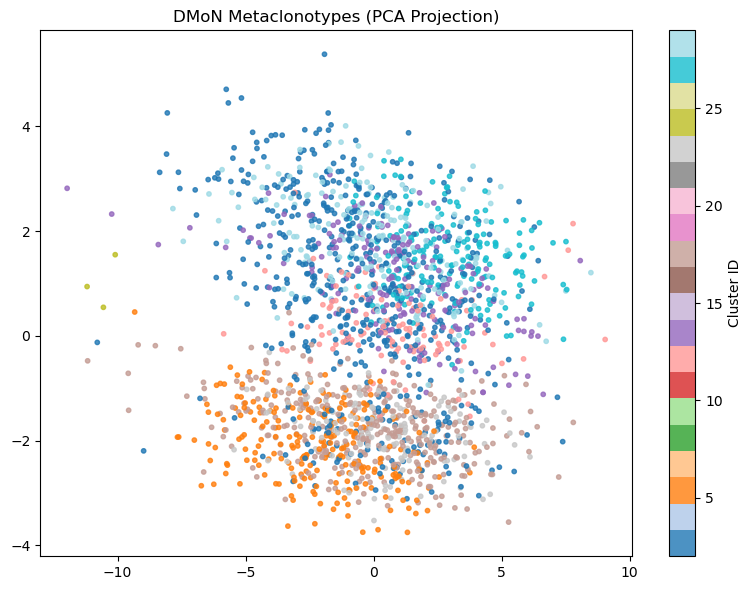

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=cluster_labels,
    cmap='tab20',
    s=10,
    alpha=0.8
)
plt.title("DMoN Metaclonotypes (PCA Projection)")
plt.colorbar(label="Cluster ID")
plt.tight_layout()
plt.show()


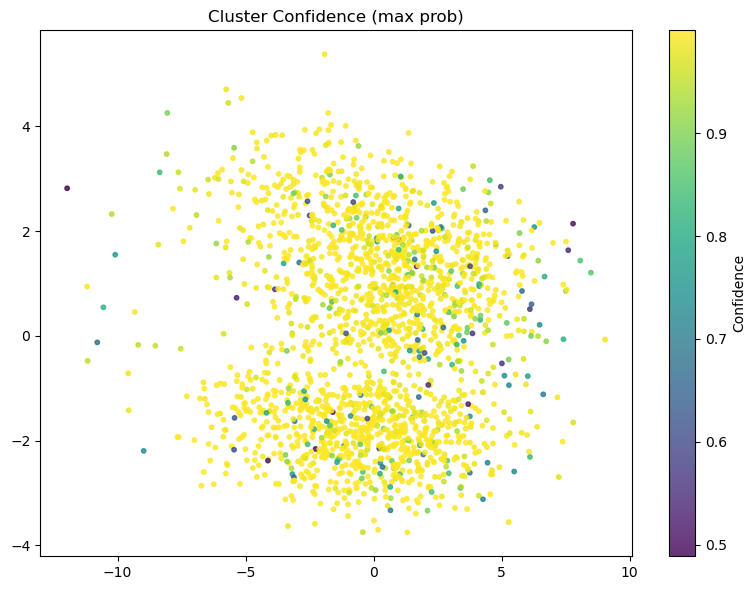

In [45]:
confidence = S_np.max(axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=confidence,
    cmap='viridis',
    s=10,
    alpha=0.8
)
plt.title("Cluster Confidence (max prob)")
plt.colorbar(label="Confidence")
plt.tight_layout()
plt.show()


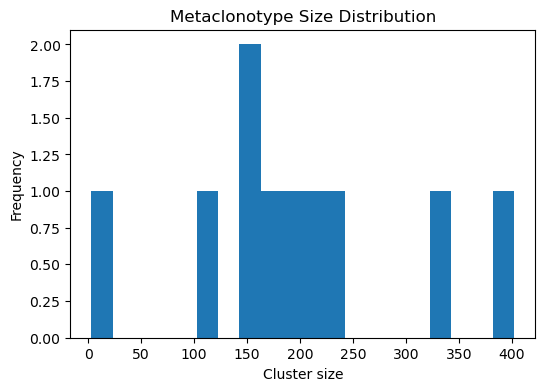

In [41]:
plt.figure(figsize=(6,4))
plt.hist(counts, bins=20)
plt.xlabel("Cluster size")
plt.ylabel("Frequency")
plt.title("Metaclonotype Size Distribution")
plt.show()


In [46]:
eps = 1e-6

P_df = (X_fingerprint_df.reindex(index=master_index, columns=hk_tcr_list, fill_value=0) > 0).astype(np.int8)
y_arr = np.asarray(y).astype(int)

case_mask = (y_arr == 1)
ctrl_mask = (y_arr == 0)

p1 = P_df.iloc[case_mask].mean(axis=0).to_numpy(dtype=np.float32)
p0 = P_df.iloc[ctrl_mask].mean(axis=0).to_numpy(dtype=np.float32)

tcr_log_enrich = np.log((p1 + eps) / (p0 + eps))  # (num_tcrs,)
tcr_prev = P_df.mean(axis=0).to_numpy(dtype=np.float32)


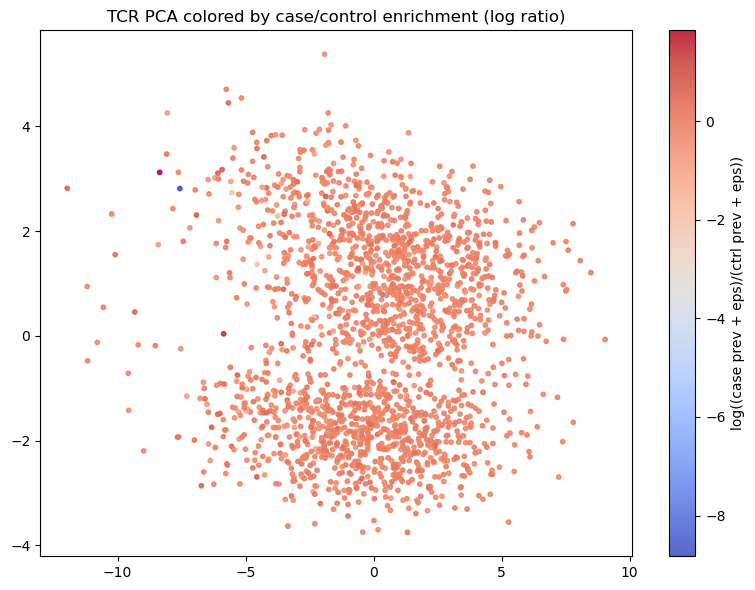

In [47]:
plt.figure(figsize=(8,6))
sc = plt.scatter(
    embedding_2d[:,0],
    embedding_2d[:,1],
    c=tcr_log_enrich,
    cmap='coolwarm',
    s=10,
    alpha=0.85
)
plt.title("TCR PCA colored by case/control enrichment (log ratio)")
plt.colorbar(sc, label="log((case prev + eps)/(ctrl prev + eps))")
plt.tight_layout()
plt.show()


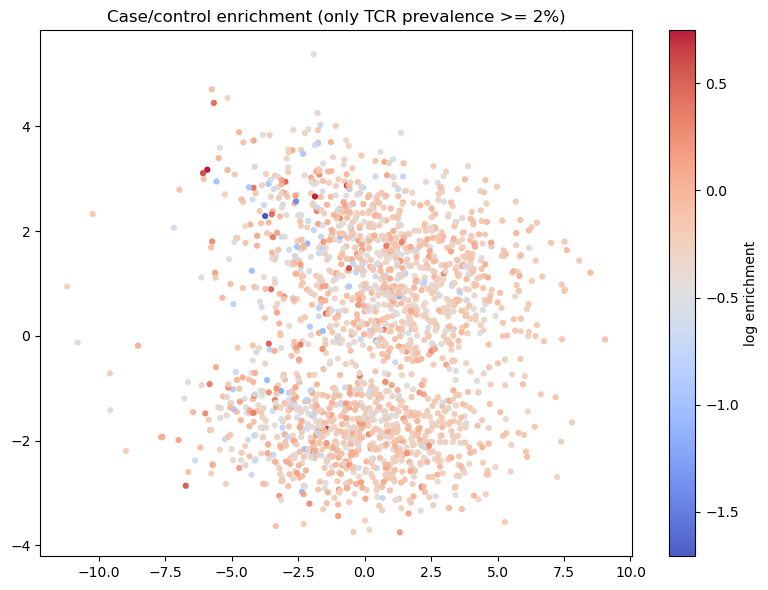

In [48]:
mask = tcr_prev >= 0.02
plt.figure(figsize=(8,6))
sc = plt.scatter(embedding_2d[mask,0], embedding_2d[mask,1], c=tcr_log_enrich[mask],
                 cmap='coolwarm', s=12, alpha=0.9)
plt.title("Case/control enrichment (only TCR prevalence >= 2%)")
plt.colorbar(sc, label="log enrichment")
plt.tight_layout()
plt.show()


Explained variance ratio: [0.2105696  0.08059507]


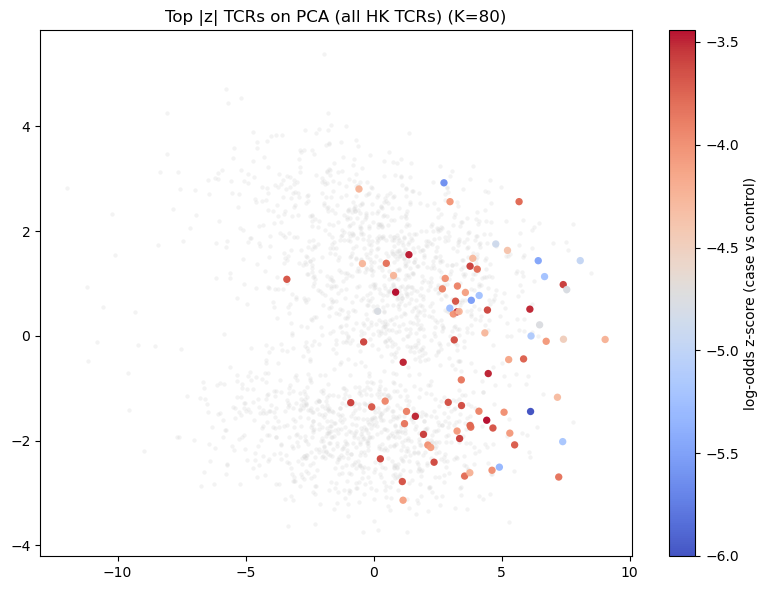

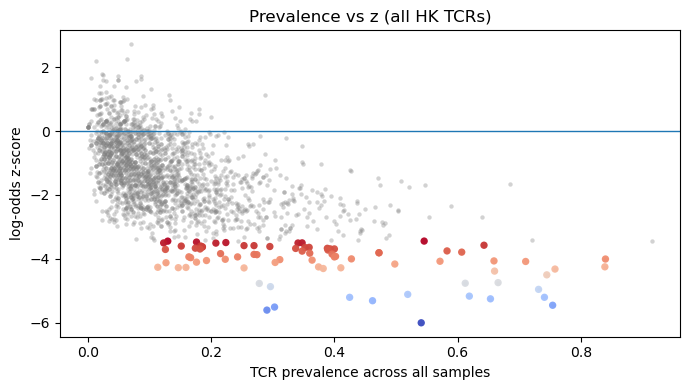

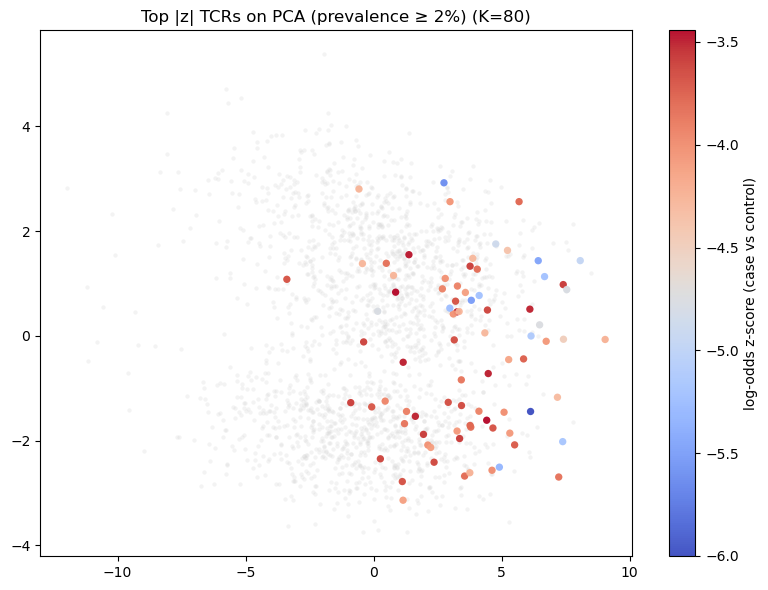

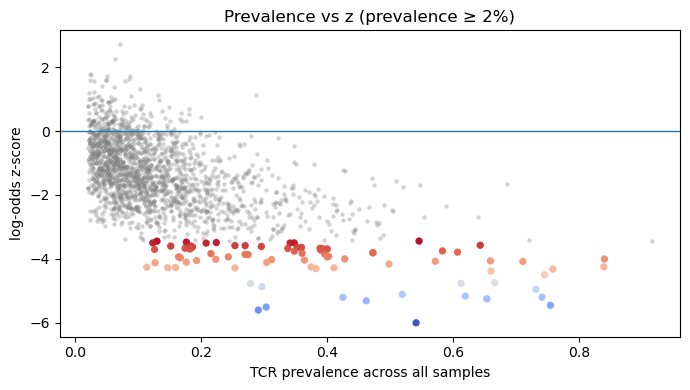

In [49]:
y_arr = np.asarray(y_final).astype(int)

master_index = pd.Index(all_sample_names, name="sample_name")
P_df = ((X_fingerprint_df.reindex(index=master_index, columns=hk_tcr_list, fill_value=0) > 0)
        .astype(np.int8))

case_mask = (y_arr == 1)
ctrl_mask = (y_arr == 0)

a = P_df.iloc[case_mask].sum(axis=0).to_numpy(dtype=np.float32)   # cases with TCR
c = P_df.iloc[ctrl_mask].sum(axis=0).to_numpy(dtype=np.float32)   # ctrls with TCR

n1 = float(case_mask.sum())
n0 = float(ctrl_mask.sum())

b = n1 - a  # cases without
d = n0 - c  # ctrls without

pc = 0.5
log_or = np.log((a + pc) * (d + pc) / ((b + pc) * (c + pc))).astype(np.float32)

se = np.sqrt(1.0 / (a + pc) + 1.0 / (b + pc) + 1.0 / (c + pc) + 1.0 / (d + pc)).astype(np.float32)
z = (log_or / se).astype(np.float32)

prev = P_df.mean(axis=0).to_numpy(dtype=np.float32)

pca = PCA(n_components=2, random_state=42)
emb2d = pca.fit_transform(X_embeddings)
print("Explained variance ratio:", pca.explained_variance_ratio_)

def plot_top_associated(mask_tcr, title_suffix, top_k=80):
    idx = np.where(mask_tcr)[0]
    z_sub = z[idx]
    prev_sub = prev[idx]
    emb_sub = emb2d[idx]

    top = np.argsort(np.abs(z_sub))[-top_k:]
    top_idx = idx[top]

    plt.figure(figsize=(8, 6))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], s=10, alpha=0.25, c="lightgray", linewidths=0)

    sc = plt.scatter(
        emb2d[top_idx, 0],
        emb2d[top_idx, 1],
        c=z[top_idx],
        cmap="coolwarm",
        s=28,
        alpha=0.95,
        linewidths=0
    )
    plt.title(f"Top |z| TCRs on PCA {title_suffix} (K={top_k})")
    plt.colorbar(sc, label="log-odds z-score (case vs control)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.scatter(prev_sub, z_sub, s=10, alpha=0.35, c="gray", linewidths=0)
    plt.scatter(prev[top_idx], z[top_idx], s=28, alpha=0.95, c=z[top_idx], cmap="coolwarm", linewidths=0)
    plt.axhline(0, linewidth=1)
    plt.xlabel("TCR prevalence across all samples")
    plt.ylabel("log-odds z-score")
    plt.title(f"Prevalence vs z {title_suffix}")
    plt.tight_layout()
    plt.show()

mask_all = np.ones(P_df.shape[1], dtype=bool)
plot_top_associated(mask_all, "(all HK TCRs)", top_k=80)

mask_prev2 = prev >= 0.02
plot_top_associated(mask_prev2, "(prevalence ≥ 2%)", top_k=80)


### eigenvectors

In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.utils import add_self_loops, coalesce
from scipy.sparse import coo_matrix, csr_matrix, diags
from scipy.sparse.linalg import eigsh

def build_weighted_undirected_knn(Xn_torch: torch.Tensor, k: int, gamma: float = 2.0):
    edge_index = knn_graph(Xn_torch, k=k, loop=False)
    src, dst = edge_index[0], edge_index[1]
    edge_index_rev = torch.stack([dst, src], dim=0)
    edge_index = torch.cat([edge_index, edge_index_rev], dim=1)
    edge_index, _ = coalesce(edge_index, None, Xn_torch.size(0), Xn_torch.size(0))

    src, dst = edge_index[0], edge_index[1]
    w = (Xn_torch[src] * Xn_torch[dst]).sum(dim=1)
    w = torch.clamp(w, min=0.0)
    if gamma is not None and gamma != 1.0:
        w = w ** float(gamma)

    edge_index, w = add_self_loops(edge_index, w, fill_value=1.0, num_nodes=Xn_torch.size(0))
    edge_index, w = coalesce(edge_index, w, Xn_torch.size(0), Xn_torch.size(0))
    return edge_index, w

def spectral_coordinates_from_graph(
    X_embeddings: np.ndarray,
    k_neighbors: int = 20,
    n_eigs: int = 16,
    gamma: float = 2.0,
    thr: float = 0.0,
    seed: int = 0,
    device: str = "cpu",
):

    X = torch.tensor(X_embeddings, dtype=torch.float32, device=device)
    Xn = F.normalize(X, p=2, dim=1)

    edge_index, edge_weight = build_weighted_undirected_knn(Xn, k=k_neighbors, gamma=gamma)

    src = edge_index[0].detach().cpu().numpy()
    dst = edge_index[1].detach().cpu().numpy()
    w = edge_weight.detach().cpu().numpy().astype(np.float64)

    if thr > 0.0:
        keep = w >= float(thr)
        src, dst, w = src[keep], dst[keep], w[keep]

    n = X_embeddings.shape[0]
    A = coo_matrix((w, (src, dst)), shape=(n, n)).tocsr()
    A = (A + A.T) * 0.5

    d = np.asarray(A.sum(axis=1)).reshape(-1).astype(np.float64)
    d = np.clip(d, 1e-12, None)
    D_inv_sqrt = diags(1.0 / np.sqrt(d), format="csr")

    L = diags(np.ones(n), format="csr") - (D_inv_sqrt @ A @ D_inv_sqrt)

    k_eigs = int(n_eigs) + 1
    k_eigs = min(k_eigs, n - 1)

    vals, vecs = eigsh(L, k=k_eigs, which="SM")
    order = np.argsort(vals)
    vals, vecs = vals[order], vecs[:, order]

    phi = vecs[:, 1:k_eigs].astype(np.float32)

    return phi, vals

def build_sample_topology_features(
    phi_tcr: np.ndarray,
    X_fingerprint_df: pd.DataFrame,
    all_sample_names,
    hk_tcr_list,
    y_final,
    use_idf: bool = True,
    normalize_by_hk_count: bool = True,
):
    master_index = pd.Index(all_sample_names, name="sample_name")

    P = ((X_fingerprint_df.reindex(index=master_index, columns=hk_tcr_list, fill_value=0) > 0)
         .to_numpy(dtype=np.float32))

    if use_idf:
        df = P.sum(axis=0)
        N = P.shape[0]
        idf = np.log((N + 1.0) / (df + 1.0)).astype(np.float32)
        P = P * idf[None, :]

    X_topo = P @ phi_tcr

    if normalize_by_hk_count:
        denom = P.sum(axis=1, keepdims=True)
        denom = np.clip(denom, 1e-8, None)
        X_topo = X_topo / denom

    X_topo = np.asarray(X_topo, dtype=np.float32)
    y_aligned = np.asarray(y_final, dtype=int)

    return X_topo, y_aligned


K_NEI = 20
N_EIGS = 16
GAMMA = 2.0
THR = 0.0
SEED = 0

phi_tcr, evals = spectral_coordinates_from_graph(
    X_embeddings=X_embeddings,
    k_neighbors=K_NEI,
    n_eigs=N_EIGS,
    gamma=GAMMA,
    thr=THR,
    seed=SEED,
    device=device,
)

print("phi_tcr shape:", phi_tcr.shape)
print("smallest eigenvalues:", evals[:10])

X_topo, y_topo = build_sample_topology_features(
    phi_tcr=phi_tcr,
    X_fingerprint_df=X_fingerprint_df,
    all_sample_names=all_sample_names,
    hk_tcr_list=hk_tcr_list,
    y_final=y_final,
    use_idf=True,
    normalize_by_hk_count=True,
)

print("X_topo shape:", X_topo.shape)

print(f"\nOptimized MLP Tuning on BASELINE X (10-Fold CV, ES={EARLY_STOP_PATIENCE}) ---")

X_tensor = torch.tensor(X_topo, dtype=torch.float32)
y_tensor = torch.tensor(y_topo, dtype=torch.long)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=R_STATE)

fold_ba_scores, fold_roc_scores, fold_precision, fold_recall, fold_f1 = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_topo, y_final)):
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)

    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    model = ClusterMLP(
        input_dim=X_topo.shape[1],
        hidden_dim=HIDDEN_DIM,
        DROPOUT=DROPOUT
    ).to(device)

    # Class-weighted CE (same)
    n0 = (y_train == 0).sum().item()
    n1 = (y_train == 1).sum().item()
    pos_weight = (n0 / n1) if n1 > 0 else 1.0
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.000009)

    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, min_lr=1e-6
    )

    best_val_ba = 0.0
    patience_counter = 0
    best_model_weights = None

    for epoch in range(N_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_test = model(X_test)
            preds_test = torch.argmax(logits_test, dim=1)
            ba_test = balanced_accuracy_score(y_test.cpu().numpy(), preds_test.cpu().numpy())

        scheduler.step(ba_test)

        if ba_test > best_val_ba:
            best_val_ba = ba_test
            patience_counter = 0
            best_model_weights = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= EARLY_STOP_PATIENCE:
            break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    model.eval()
    with torch.no_grad():
        logits_final = model(X_test)
        probs_final = torch.softmax(logits_final, dim=1)[:, 1]
        preds_final = torch.argmax(logits_final, dim=1)

    y_true = y_test.cpu().numpy()
    y_pred = preds_final.cpu().numpy()
    y_prob = probs_final.cpu().numpy()

    ba = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    fold_ba_scores.append(ba)
    fold_roc_scores.append(roc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)

    print(f"Fold {fold+1} (Best BA: {best_val_ba:.4f}): BA={ba:.4f}, AUC={roc:.4f}")

print("\n--- Final Results (Optimized MLP on BASELINE Features) ---")
print(f"Mean Balanced Accuracy: {np.mean(fold_ba_scores):.4f} ± {np.std(fold_ba_scores):.4f}")
print(f"Mean ROC-AUC:           {np.mean(fold_roc_scores):.4f} ± {np.std(fold_roc_scores):.4f}")
print(f"Mean Precision:         {np.mean(fold_precision):.4f} ± {np.std(fold_precision):.4f}")
print(f"Mean Recall:            {np.mean(fold_recall):.4f} ± {np.std(fold_recall):.4f}")
print(f"Mean F1:                {np.mean(fold_f1):.4f} ± {np.std(fold_f1):.4f}")

phi_tcr shape: (1997, 16)
smallest eigenvalues: [6.11400548e-17 3.26503405e-03 7.34394646e-03 8.63129713e-03
 1.22056282e-02 1.57531755e-02 1.90369222e-02 2.33731119e-02
 3.98523732e-02 4.08354288e-02]
X_topo shape: (1050, 16)

Optimized MLP Tuning on BASELINE X (10-Fold CV, ES=60) ---
Fold 1 (Best BA: 0.5987): BA=0.5987, AUC=0.5538
Fold 2 (Best BA: 0.6868): BA=0.6868, AUC=0.6739
Fold 3 (Best BA: 0.6494): BA=0.6494, AUC=0.6234
Fold 4 (Best BA: 0.6374): BA=0.6374, AUC=0.6168
Fold 5 (Best BA: 0.6144): BA=0.6144, AUC=0.6205
Fold 6 (Best BA: 0.6653): BA=0.6653, AUC=0.6691
Fold 7 (Best BA: 0.5975): BA=0.5975, AUC=0.5601
Fold 8 (Best BA: 0.5607): BA=0.5607, AUC=0.4806
Fold 9 (Best BA: 0.5888): BA=0.5888, AUC=0.6093
Fold 10 (Best BA: 0.6346): BA=0.6346, AUC=0.6185

--- Final Results (Optimized MLP on BASELINE Features) ---
Mean Balanced Accuracy: 0.6234 ± 0.0364
Mean ROC-AUC:           0.6026 ± 0.0546
Mean Precision:         0.6047 ± 0.0502
Mean Recall:            0.5419 ± 0.1653
Mean F1:    

# T-sne

Calculating t-SNE projection for visualization...
t-SNE calculation complete.


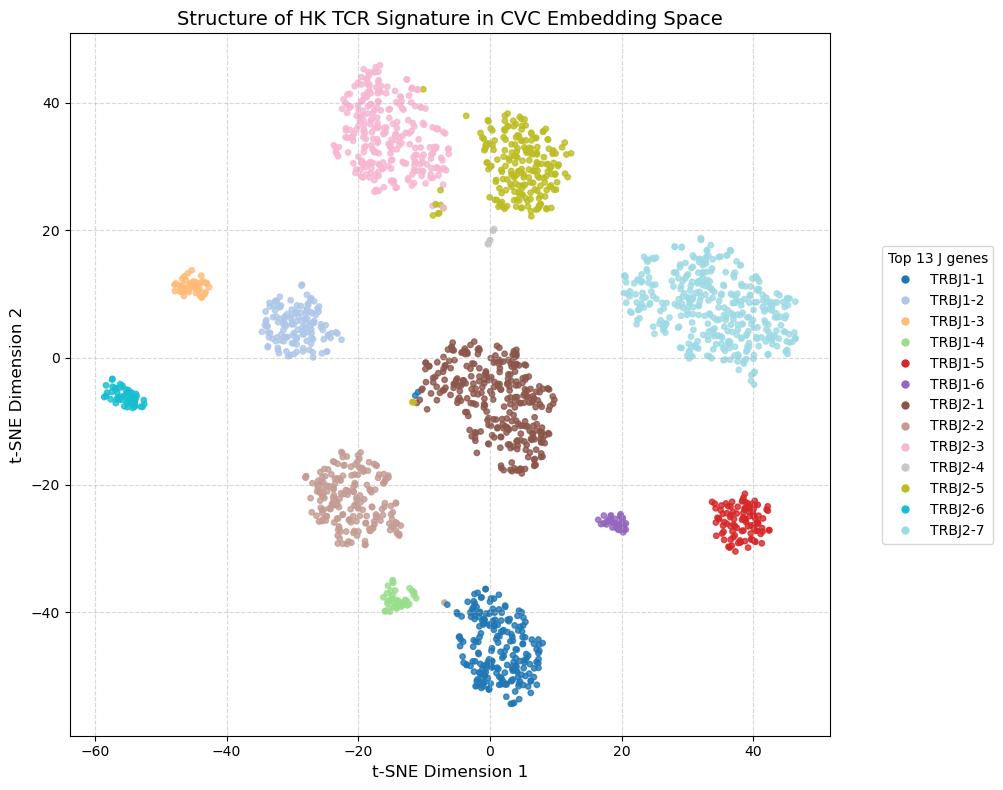

Generated tcr_embedding_structure.png


In [108]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE # t-SNE is great for visualizing clusters
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# --- ASSUMPTIONS ---
# X_embeddings: NumPy array of CVC Embeddings (1997, 768)
# hk_tcr_list: List of the 1997 TCR sequences (for indexing)
# V_total_df: DataFrame containing the source data, including 'V_gene_fast_id'

hk_tcr_list_tsne = hk_tcr_list.copy()

X_embeddings_tsne = cvc_lookup_df.fillna(0).to_numpy(dtype=np.float32)

# 1. Prepare Data and Labels
tcr_df = V_total_df.set_index('cdr3_seq').reindex(hk_tcr_list)

# These are your REAL V-gene values (strings or ints)
gene_labels_raw = tcr_df['J_gene_fast'].fillna('Unknown').astype(str).values

# Encode *only* for coloring
le = LabelEncoder()
gene_labels_encoded = le.fit_transform(gene_labels_raw)

# KEEP ORIGINAL names for legend (not the encoded version)
gene_names = np.array(gene_labels_raw)     # real labels
unique_gene_names = np.unique(gene_names)  # unique real labels
N_GENES = len(unique_gene_names)
# 2. Compute t-SNE
print("Calculating t-SNE projection for visualization...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,
    random_state=42,
    metric='cosine',
    learning_rate='auto'
)
X_2d = tsne.fit_transform(X_embeddings)
print("t-SNE calculation complete.")

# 3. Create discrete colormap with N colors
cmap = plt.colormaps.get_cmap('tab20').resampled(N_GENES)

# 4. Plot
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=gene_labels_encoded,
    cmap=cmap,
    s=15,
    alpha=0.8
)

# Build custom legend (handles + REAL gene names)
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=6,
        markerfacecolor=cmap(i),
        markeredgecolor='none'
    )
    for i in range(N_GENES)
]

MAX_LEGEND = 20
n_show = min(MAX_LEGEND, N_GENES)

fig.legend(
    handles[:n_show],
    unique_gene_names[:n_show],          # <-- REAL NAMES HERE
    title=f"Top {n_show} J genes",
    bbox_to_anchor=(0.88, 0.5),
    loc='center left'
)

ax.set_title("Structure of HK TCR Signature in CVC Embedding Space", fontsize=14)
ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

print("Generated tcr_embedding_structure.png")

T-sne